# Look at Runs With Backlash 
Runs involve reversal of the goniometer motor. This results in backlash, were multiple nudges are needed before movement occurs.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics
pd.set_option('display.max_columns',500)

In [2]:
df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")

/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_60842/1971075393.py:1: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("csv_data/merged/Spring2020Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_60842/1971075393.py:2: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("csv_data/merged/Spring2023Merged_goodRuns.csv")
/var/folders/tp/y19c81b92lsc5dbbpwb5b0wh0000gn/T/ipykernel_60842/1971075393.py:3: DtypeWarning: Columns (31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("csv_data/merged/Spring2025Merged_goodRuns.csv")


In [3]:
# select runs with a nudge, and potential backlash based on motor inputs
def select_data(df_in):
    df_out = df_in[(df_in['RunHasNudge'])&(df_in['RunHasBacklash'])&(df_in['goodRun'])]
    return df_out
df_2020_good = select_data(df_2020)
df_2023_good = select_data(df_2023)
df_2025_good = select_data(df_2025)


In [4]:
# copy viz code from other notebook (or make it a utility aviailble to all would be better)
backlash_runs_2020 = df_2020_good['RunNumber'].unique()
backlash_runs_2023 = df_2023_good['RunNumber'].unique()
backlash_runs_2025 = df_2025_good['RunNumber'].unique()

In [5]:
print(len(backlash_runs_2020))

128


In [6]:
print(df_2020_good.columns)

Index(['Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE', 'GONI:ROLL',
       'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y', 'GONI:Y.RBV',
       'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW', 'GONI:YAW.RBV', 'AC:X',
       'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY', 'EBEAM:X', 'EBEAM:Y',
       'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC', 'CBREM:ENERGY', 'RADIATOR:ID',
       'RADIATOR:NAME', 'goodRun', 'TimeStamp', 'RunHasNudge',
       'NudgeDuringRun', 'NudgeOccurred', 'TotalNudgeSize_thisRun',
       'NudgeSequence', 'NudgeSequenceReduced_Correct',
       'NudgeSequenceReduced_Naive', 'TotalNudges_thisRun',
       'RunHasAbnormalNudge', 'RunHasBacklash', 'ConfigChange_inProgress',
       'BacklashNudge', 'NudgeNumber', 'NudgePitchSize', 'NudgeYawSize',
       'PitchMotionSize', 'YawMotionSize', 'MotionDone', 'NudgeEnSize_10s',
       'CBREM:ENERGY_LAG_ADJUSTED'],
      dtype='object')


In [7]:
print(df_2020_good['BacklashNudge'].value_counts())

BacklashNudge
False    790065
True        379
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import statistics
pd.set_option('display.max_columns',500)

def plot_run(df_in, runNumber):
    runNumber = int(runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900


    print("plotting for run ",runNumber)

    # get df for just this run
    df_run = df_in[df_in['RunNumber']==runNumber]
    df_run.reset_index(inplace=True)

    print("Full nudge sequence is ",df_run['NudgeSequence'].mode())
    print("Reduced nudge sequence is ",df_run['NudgeSequenceReduced_Naive'].mode())
    print("Reduced nudge sequence w/ backlash is ",df_run['NudgeSequenceReduced_Correct'].mode())


    print(df_run['TotalNudges_thisRun'].unique(),"nudges this run")

    # only want to display neighborhood around nudges, so find time of first nudge
    df_first_nudge = df_run[df_run['NudgeNumber']==1]
    if df_first_nudge.empty:
        print("ERROR: First nudge df is empty, skipping Run",runNumber)
        return
    df_first_nudge.reset_index(inplace=True,drop=True)
    first_nudge_time = df_first_nudge.loc[0,'TimeStamp']

    df_run_nudges = df_run[(df_run['NudgeOccurred'])&(df_run['NudgeNumber']>=1)]

    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_run[(df_run['DAQ:STATUS']==2)]
    df_daq_on.reset_index(inplace=True)
    daq_on_time = -100
    if not df_daq_on.empty:
        daq_on_time = df_daq_on.loc[0,'TimeStamp']

    max_nudge_time = df_run_nudges['TimeStamp'].max()
    # df for all times
    df_vis = df_run[(df_run['TimeStamp']>=first_nudge_time-30)&(df_run['TimeStamp']<=(max(daq_on_time,max_nudge_time)+30))&(df_run['CBREM:ENERGY']>minE)&(df_run['CBREM:ENERGY']<maxE)]
    df_vis.reset_index(inplace=True)


    nudge_list = df_run_nudges['NudgeNumber'].unique()

    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
    
    up_nudge_label_set = False
    down_nudge_label_set = False
    backlash_label_set = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []

    first_nudge_time = 0

    # should be a list, can have backlash in both directions
    init_backlash_times = []# time of first backlash nudge
    end_backlash_times = []# time of last nudge to clear the backlash

    nudge_str = df_run_nudges['NudgeSequence'].mode()[0]
    if len(nudge_str)!=max(nudge_list):
        print("nudge_str length doesn't match nudge_list length")
        print(len(nudge_str))
        print(nudge_str)
        print(nudge_list)

    for seq in nudge_list:
       
        print("seq val is ",seq)
        nudge_dir = nudge_str[seq-1]
        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        df_this_nudge.reset_index(inplace=True)
        nudge_time = df_this_nudge.loc[0,'TimeStamp']

        if first_nudge_time==0:
            first_nudge_time = nudge_time

        current_pitchDiff = df_this_nudge.loc[0,'NudgePitchSize']        
        current_yawDiff = df_this_nudge.loc[0,'NudgeYawSize']

        nudge_has_backlash = df_this_nudge.loc[0,'BacklashNudge']

        # some changes are above 1 degree, likely config change
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            


        
        if nudge_has_backlash:
            init_backlash_times.append(nudge_time)
            end_backlash_times.append(nudge_time)
            if not backlash_label_set:
                ax1.axvline(nudge_time,color='gray',linestyle='--',label='Backlash')
                backlash_label_set = True 
            else:
                ax1.axvline(nudge_time,color='gray',linestyle='--')
        else:
            if nudge_dir=='u':
                if not up_nudge_label_set:
                    ax1.axvline(nudge_time,color='lime',linestyle='--',label='Up Nudge')
                    up_nudge_label_set = True
                else:
                    ax1.axvline(nudge_time,color='lime',linestyle='--')
            if nudge_dir=='d':
                if not down_nudge_label_set:
                    ax1.axvline(nudge_time,color='r',linestyle='--',label='Down Nudge')
                    down_nudge_label_set = True
                else:
                    ax1.axvline(nudge_time,color='r',linestyle='--')


 
    # df to get 30 seconds after daq on or last nudge, which ever is later 
    df_end = df_run[(df_run['TimeStamp']>=max(max_nudge_time,daq_on_time))]
    df_end.reset_index(inplace=True)

    end_times = list(df_end.loc[0:60,'TimeStamp'])
    if len(end_times)==0:
        end_times.append(max_nudge_time+15)

    ax2.plot(nudge_times,yawDiffs,marker='o',label='Yaw Diff')
    ax2.plot(nudge_times,pitchDiffs,marker='o',label='Pitch Diff')




    if len(end_times)>0:
        ax1.axvline(daq_on_time,color='black',label='DAQ On')

        if end_times[0]>max_nudge_time:
            nudge_times+=end_times
            

        # for more than one backlash event, 
    for i in range(len(init_backlash_times)):
        ax1.axvspan(init_backlash_times[i],end_backlash_times[i]+15,color='gray',alpha=0.1)


    plt.xlabel("Time Stamp (s)")


    ax1.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'],color='b')
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    
    ax1.axhspan(expectedE-10,expectedE+10,color='g',alpha=0.1)
    ax1.axhline(expectedE,color='g',linestyle='--')

    ax2.legend()
    
    plane_value = df_end.loc[0,'CBREM:PLANE']

    plane_str = 'PARA'
    if plane_value==2:
        plane_str = "PERP"
    elif plane_value==0:
        plane_str = " Undefined"

    radiator_name = df_vis['RADIATOR:NAME'].mode()[0]
    if "Undefined" not in radiator_name:
        radiator_name = radiator_name.strip('deg')
    print(df_vis['RADIATOR:NAME'].value_counts())
    
    titleStr = 'Run '+str(runNumber)+" "+plane_str+" "+radiator_name+plane_str
    
    ax1.set_title(titleStr)

    ax1.set_ylabel("Photon Energy (GeV)")
    ax1.legend()

    

    
    plt.savefig("plots/backlash/plot_run_"+str(runNumber)+".pdf")
    plt.show()

    plt.clf()


In [ ]:
# all the plots that go in the overleaf doc 
plot_run(df_2020_good,72257)
plot_run(df_2020_good,73263)
plot_run(df_2020_good,72127)

In [ ]:
plot_run(df_2020_good,72388)
plot_run(df_2020_good,72815)

In [ ]:
print(df_2020_good.columns)

In [ ]:
df_tmp = df_2020[(df_2020['RunNumber']>=72420)&(df_2020['RunNumber']<=72434)]
df_tmp = df_tmp[df_tmp['NudgeOccurred']]
df_tmp = df_tmp[['RunNumber','GONI:YAW','GONI:PITCH','TimeStamp','NudgeOccurred','BacklashNudge']]
df_tmp.to_csv("tmp2.csv")

In [ ]:
for runNum in backlash_runs_2020:
    plot_run(df_2020_good,runNum)

plotting for run  120311
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 120311
plotting for run  120313
Full nudge sequence is  0    dud
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 0/90 deg    140
Name: count, dtype: int64


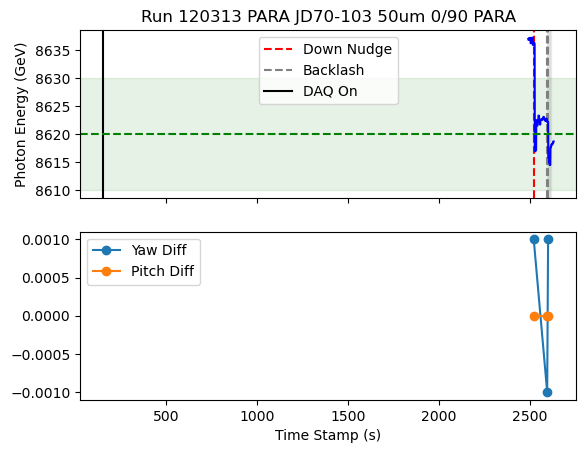

plotting for run  120315
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    1695
Undefined                     26
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

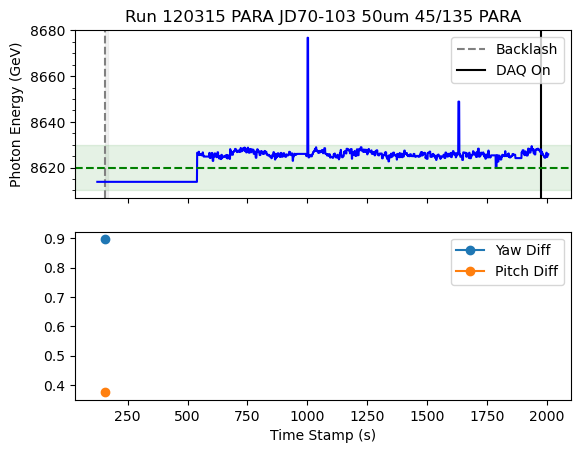

plotting for run  120322
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    253
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

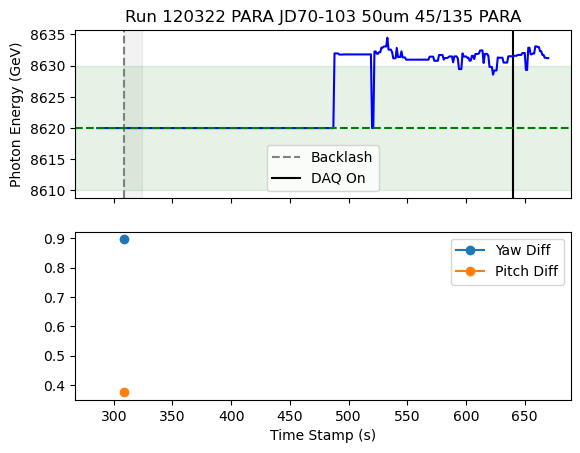

plotting for run  120353
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    239
Undefined                    16
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

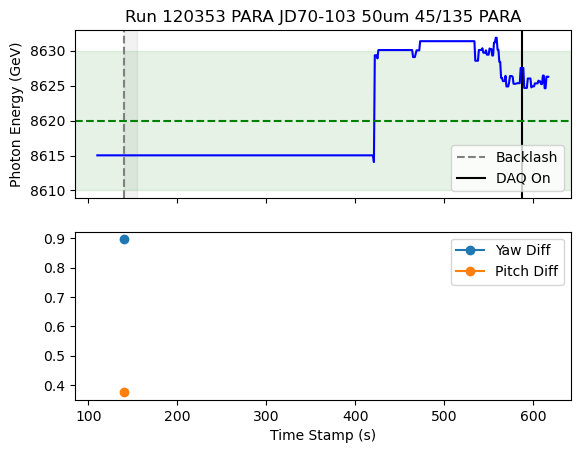

plotting for run  120372
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    727
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

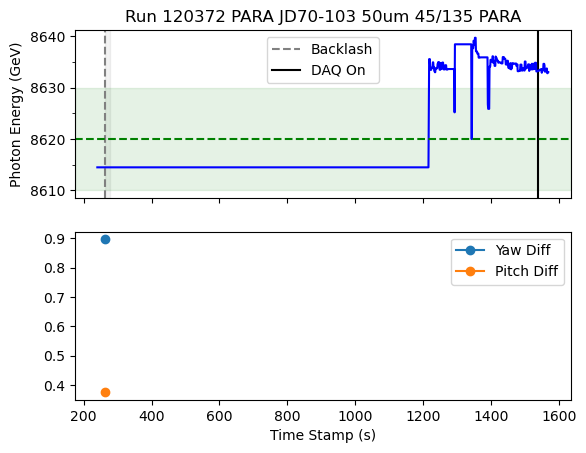

plotting for run  120398
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    633
Undefined                     5
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

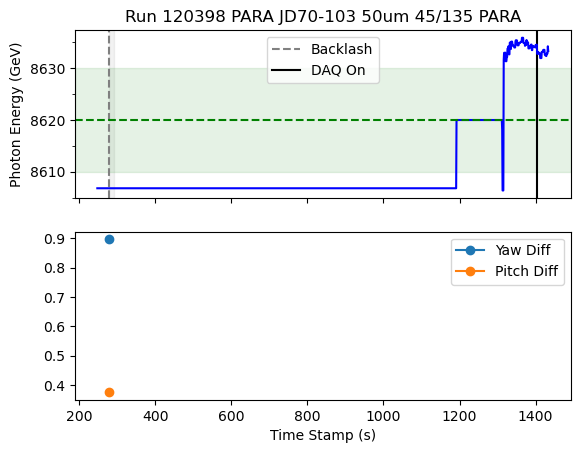

plotting for run  120404
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    135
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

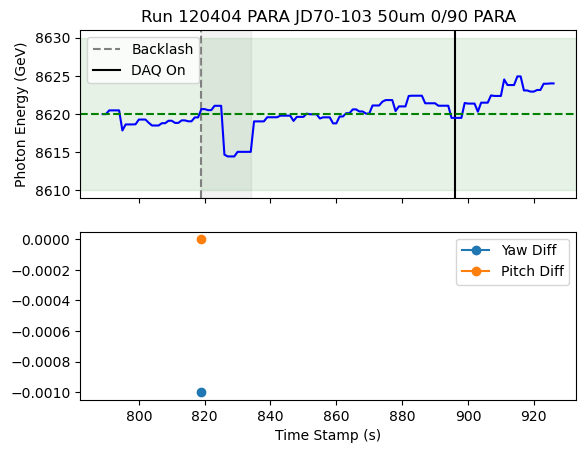

plotting for run  120406
Full nudge sequence is  0    uuuuudddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[11] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
RADIATOR:NAME
JD70-103 50um 0/90 deg    266
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

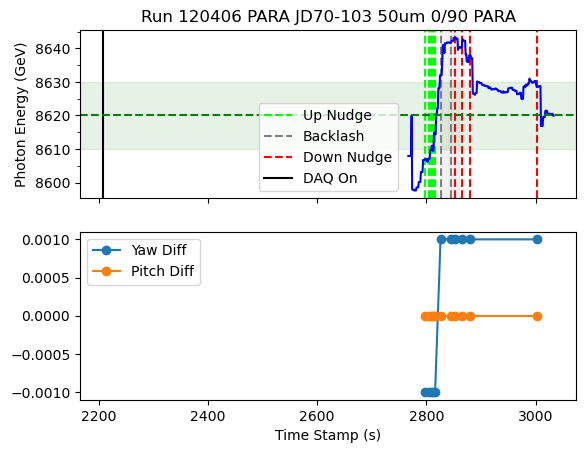

plotting for run  120411
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    315
Undefined                    21
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

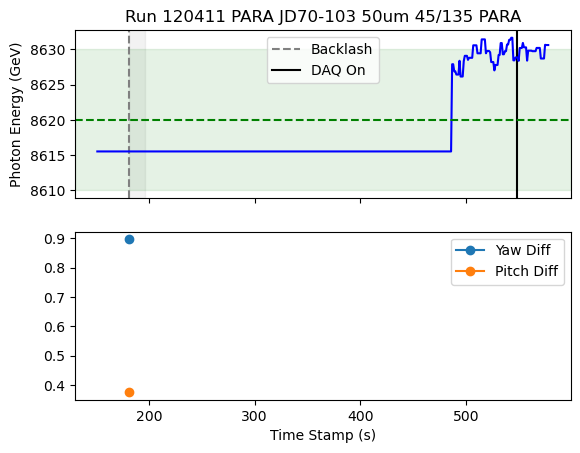

plotting for run  120420
Full nudge sequence is  0    ddduu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD70-103 50um 0/90 deg    485
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

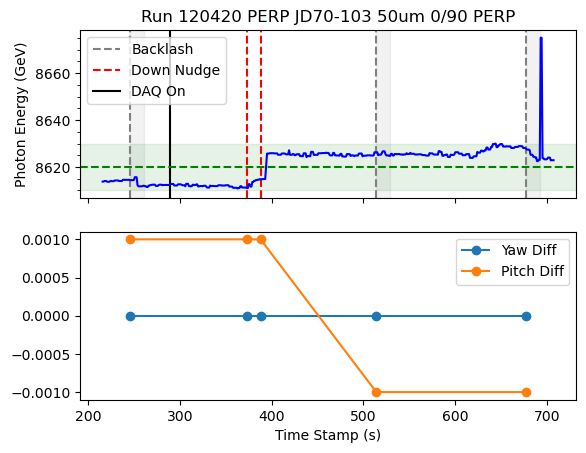

plotting for run  120437
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    211
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

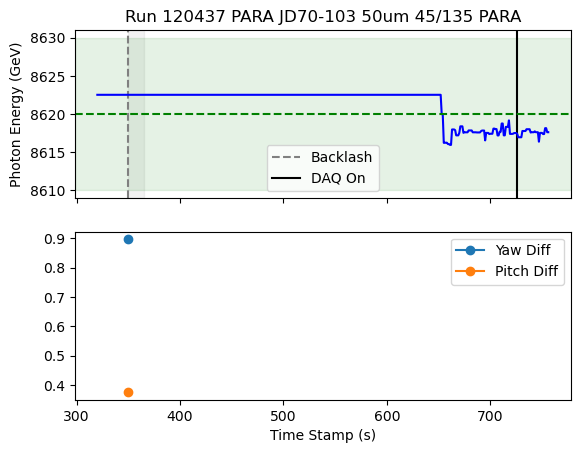

plotting for run  120451
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    294
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

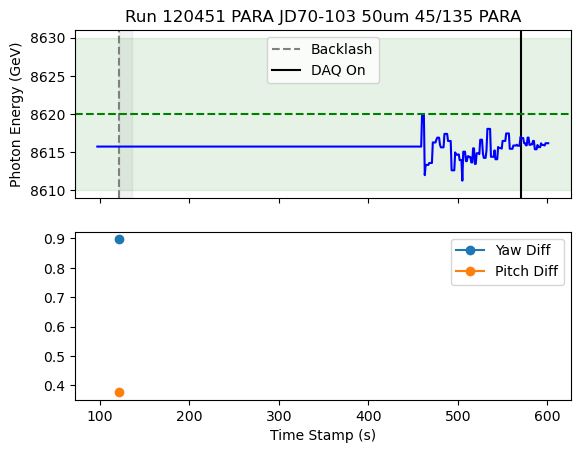

plotting for run  120470
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    163
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

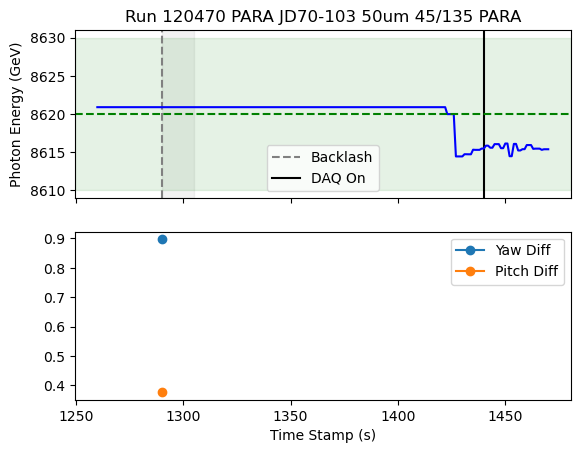

plotting for run  120536
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    353
Undefined                     2
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

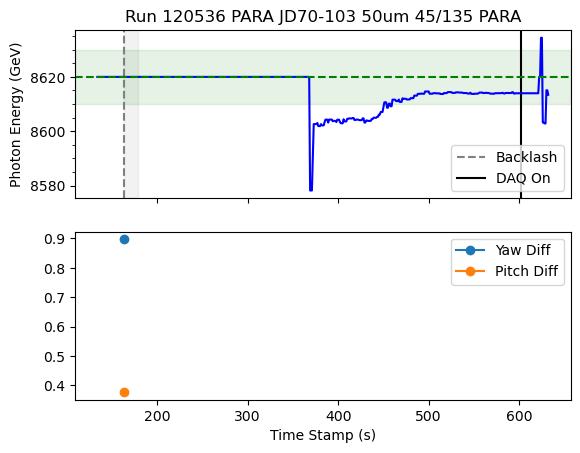

plotting for run  120541
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    62
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

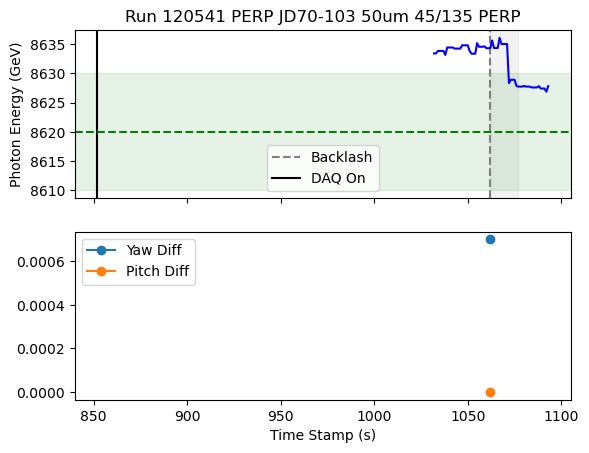

plotting for run  120562
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    176
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

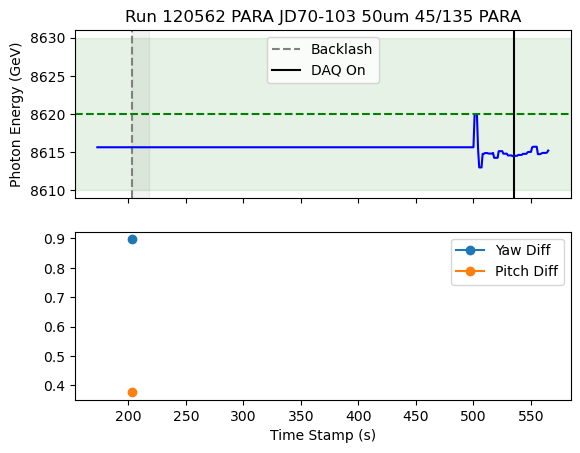

plotting for run  120566
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    80
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

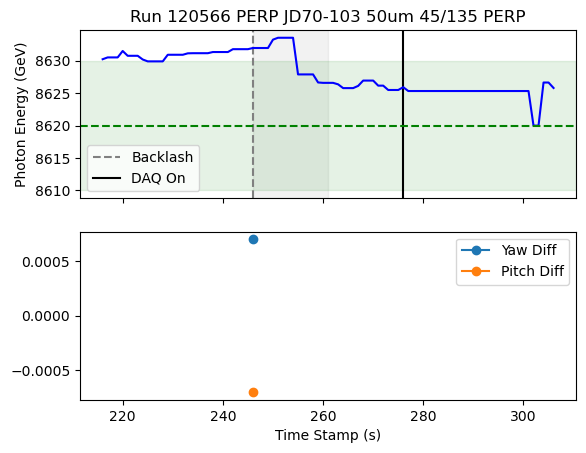

plotting for run  120606
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    125
Undefined                     9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

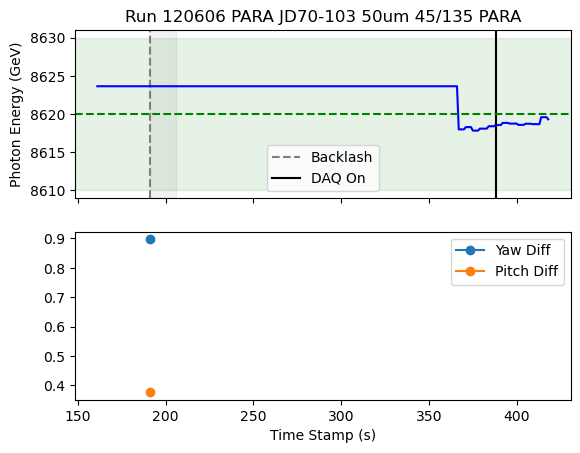

plotting for run  120643
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    212
Undefined                     9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

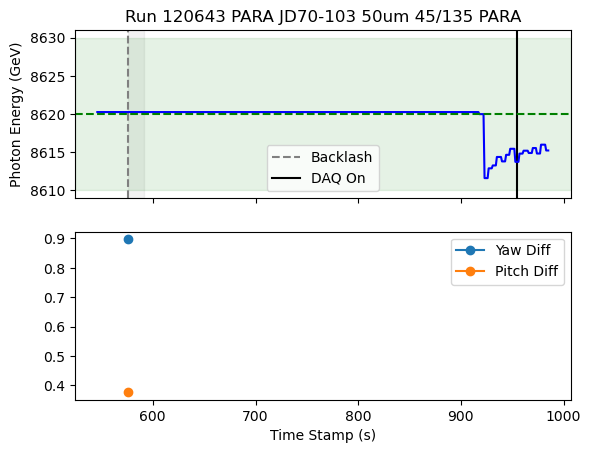

plotting for run  120663
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    207
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

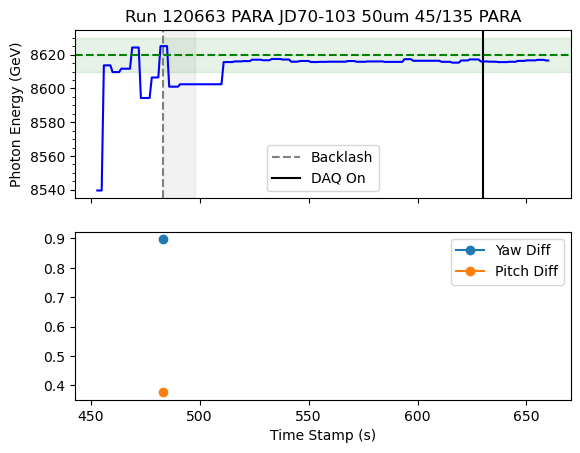

plotting for run  120687
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    194
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

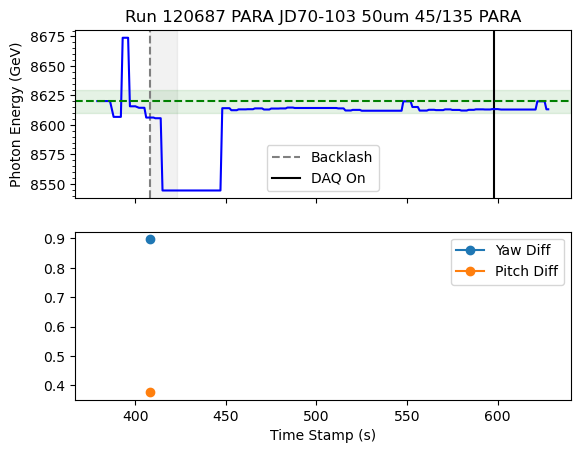

plotting for run  120706
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 120706
plotting for run  120710
Full nudge sequence is  0    uuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD70-103 50um 45/135 deg    169
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

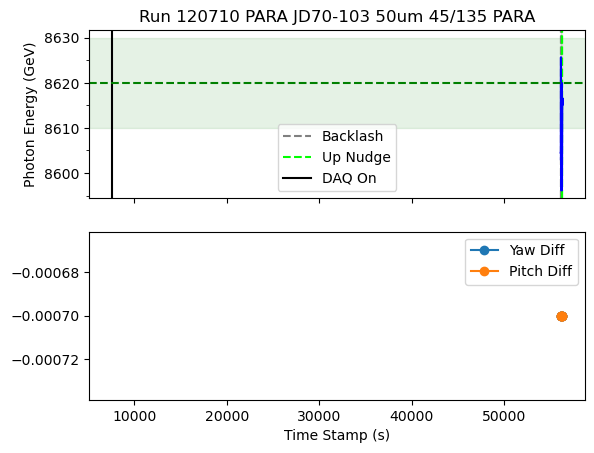

plotting for run  120722
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    430
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

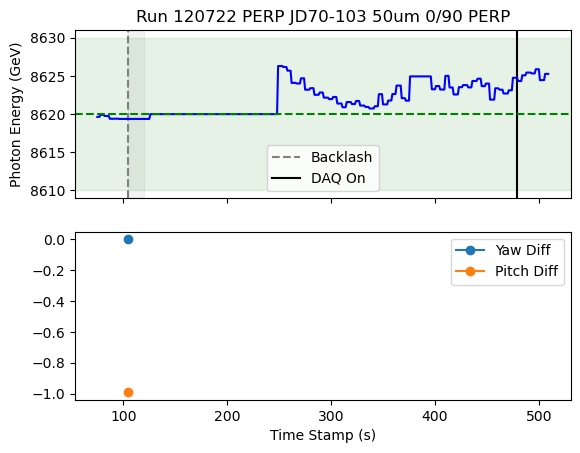

plotting for run  120724
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    128
Undefined                    18
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

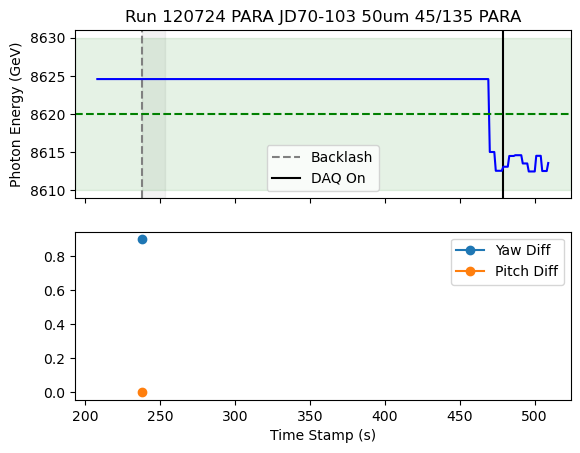

plotting for run  120740
Full nudge sequence is  0    dudduuudddduuudduuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[24] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
RADIATOR:NAME
JD70-103 50um 45/135 deg    1905
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

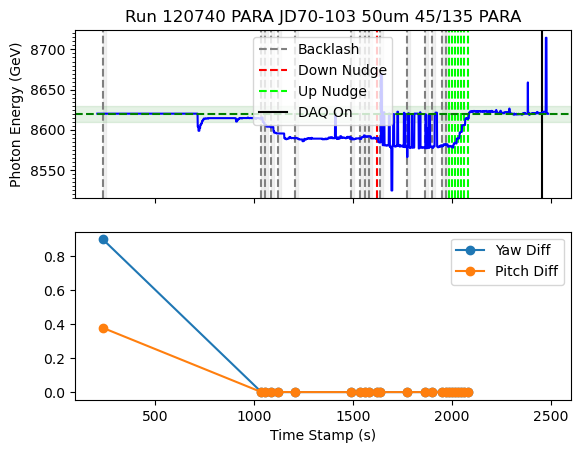

plotting for run  120753
Full nudge sequence is  0    dddduuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD70-103 50um 45/135 deg    796
Undefined                    11
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

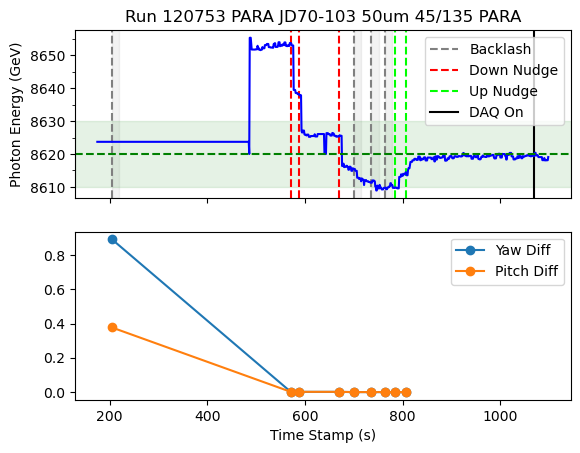

plotting for run  120762
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    308
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

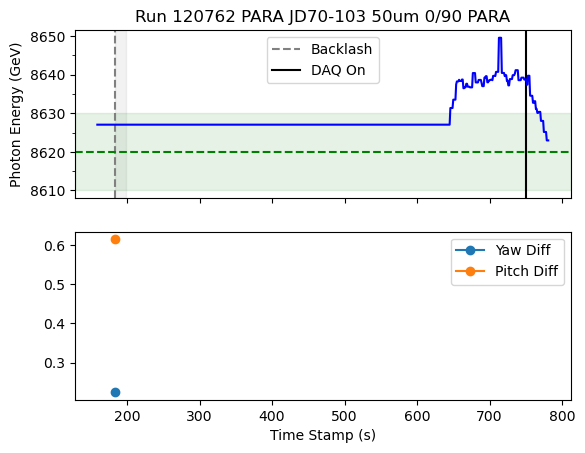

plotting for run  120768
Full nudge sequence is  0    duuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD70-103 50um 45/135 deg    737
Undefined                     5
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

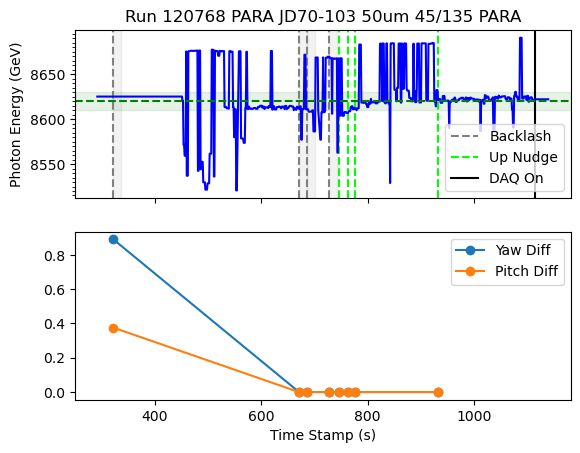

plotting for run  120782
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    186
Undefined                    17
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

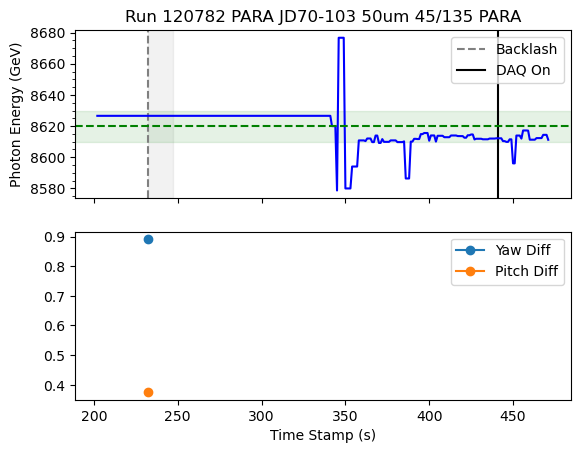

plotting for run  120787
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    242
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

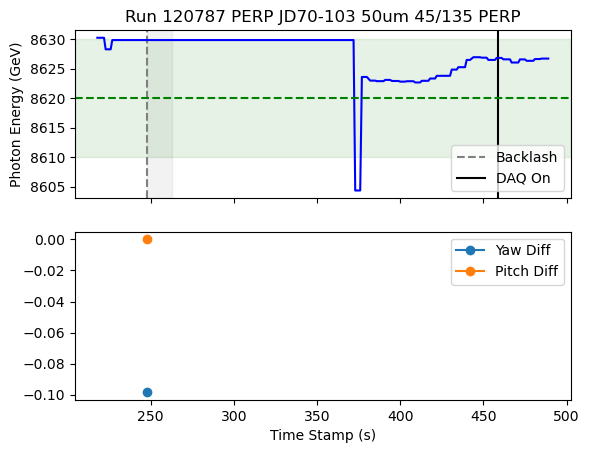

plotting for run  120798
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    196
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

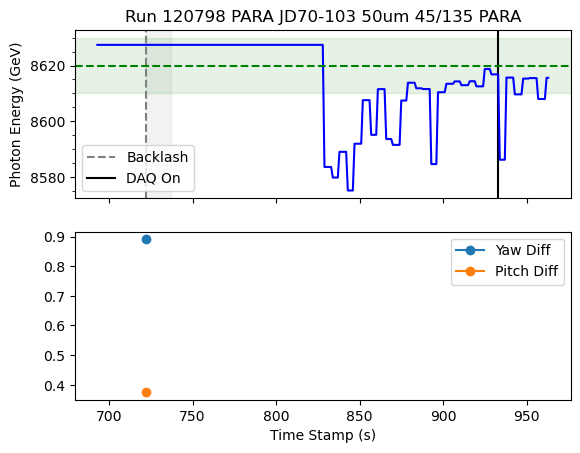

plotting for run  120801
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 120801
plotting for run  120813
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    233
Undefined                     9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

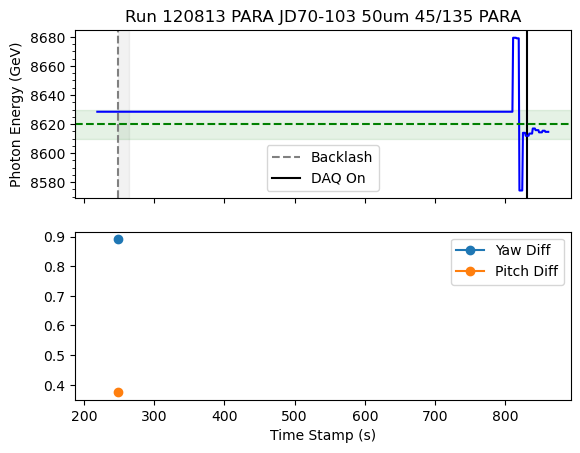

plotting for run  120821
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 45/135 deg    122
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

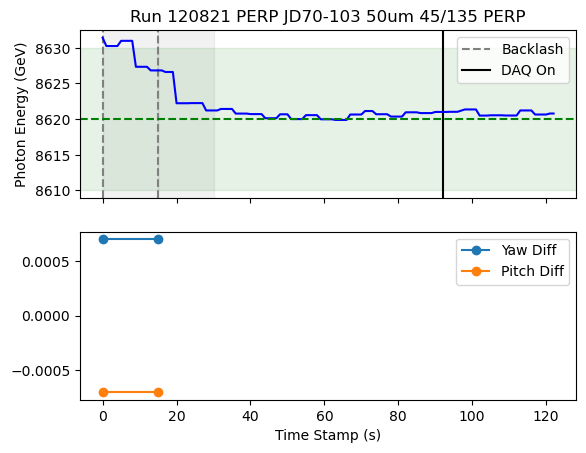

plotting for run  120826
Full nudge sequence is  0    uuuuuuuuuduu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[12] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
RADIATOR:NAME
JD70-103 50um 45/135 deg    1946
Undefined                    143
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

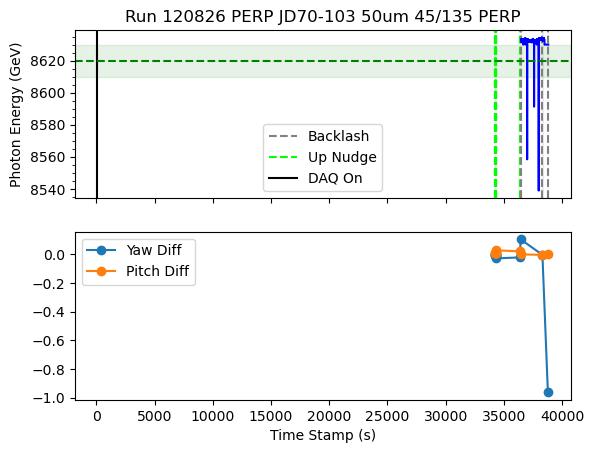

plotting for run  120827
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 120827
plotting for run  120828
Full nudge sequence is  0    uu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 45/135 deg    146
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

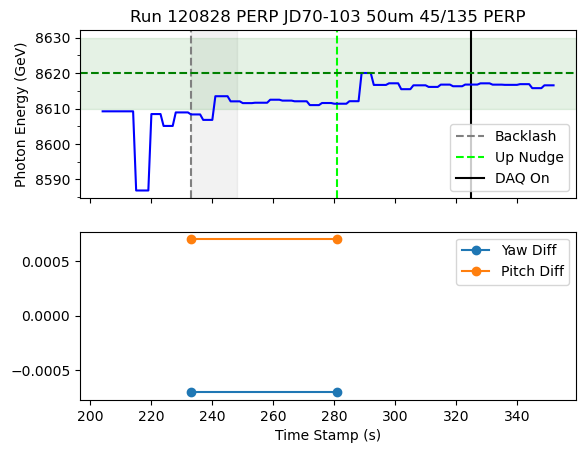

plotting for run  120834
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 0/90 deg    86
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

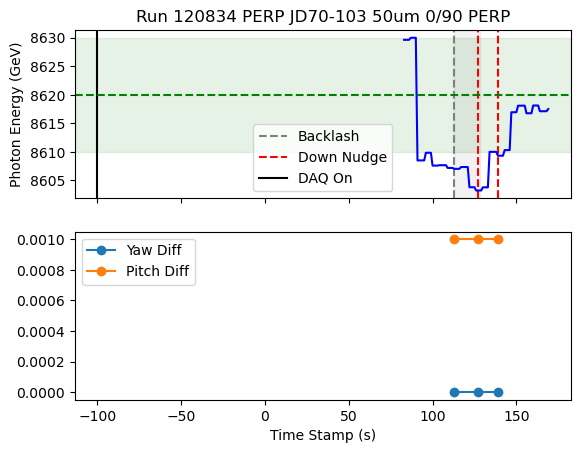

plotting for run  120837
Full nudge sequence is  0    ddduuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD70-103 50um 45/135 deg    346
Undefined                    16
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

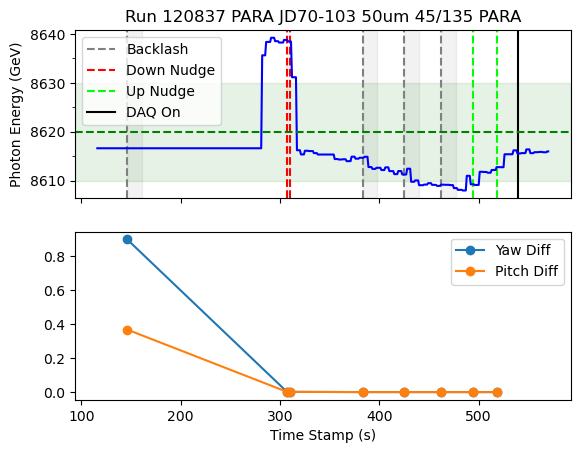

plotting for run  120843
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    60
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

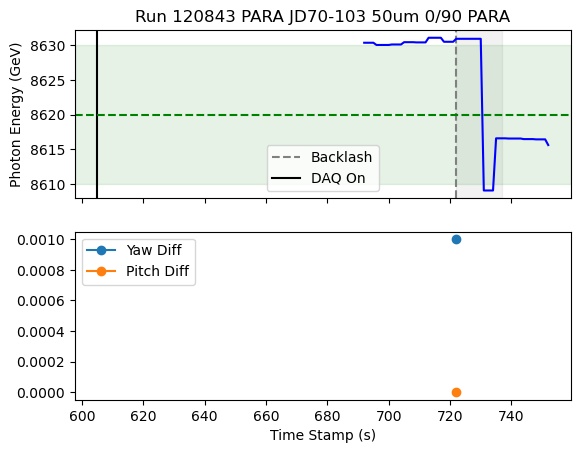

plotting for run  120848
Full nudge sequence is  0    dddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD70-103 50um 0/90 deg    170
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

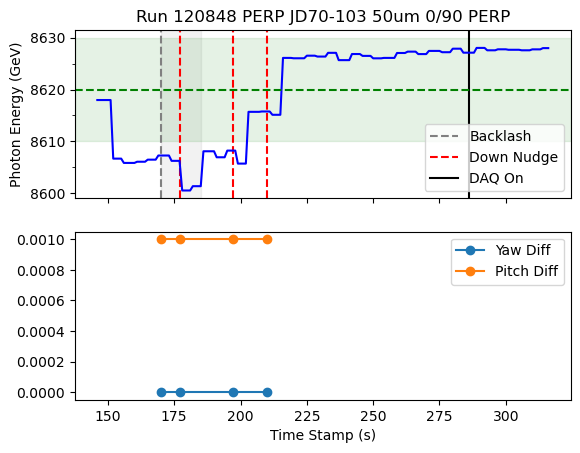

plotting for run  120850
Full nudge sequence is  0    ddduuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD70-103 50um 45/135 deg    282
Undefined                     1
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

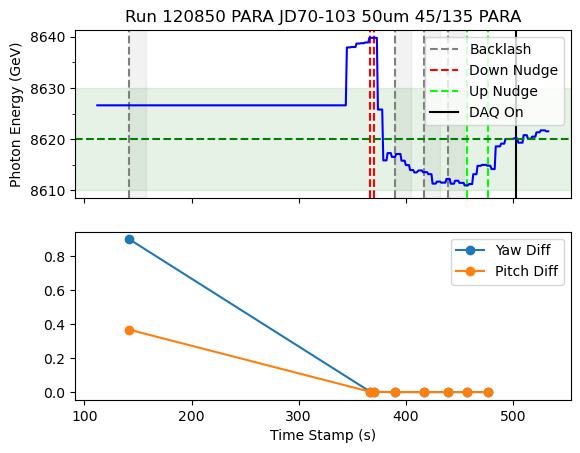

plotting for run  120852
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 45/135 deg    122
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

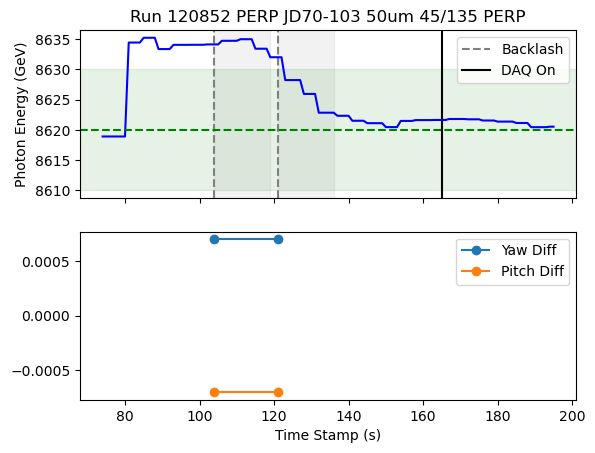

plotting for run  120857
Full nudge sequence is  0    dddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD70-103 50um 0/90 deg    333
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

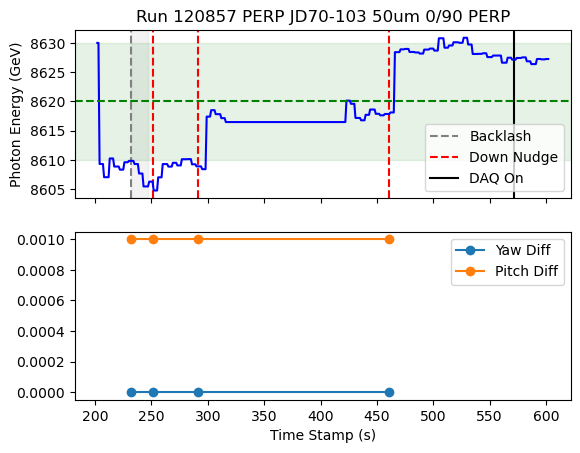

plotting for run  120885
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    265
Undefined                    21
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

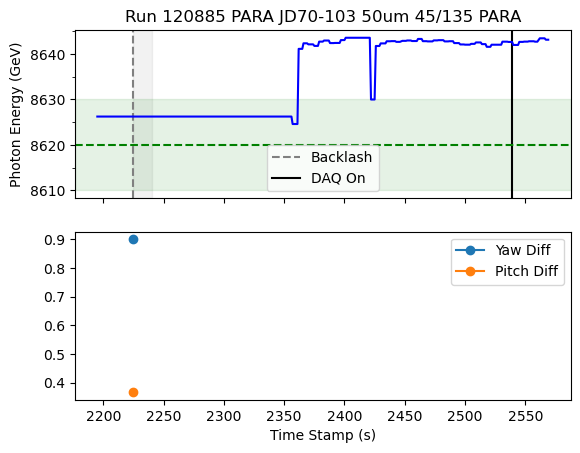

plotting for run  120886
Full nudge sequence is  0    dduuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[7] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
RADIATOR:NAME
JD70-103 50um 45/135 deg    244
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

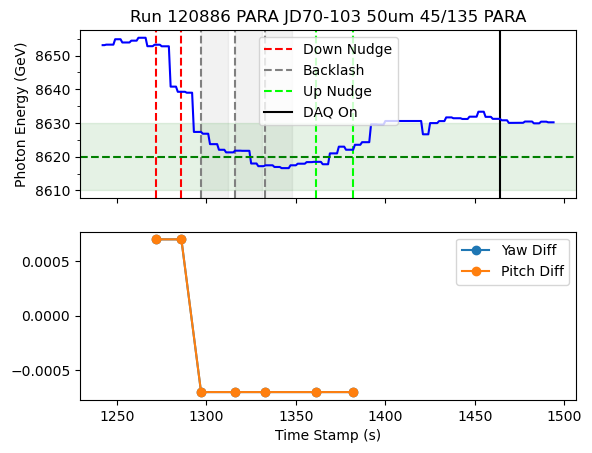

plotting for run  120894
Full nudge sequence is  0    dddu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD70-103 50um 0/90 deg    256
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

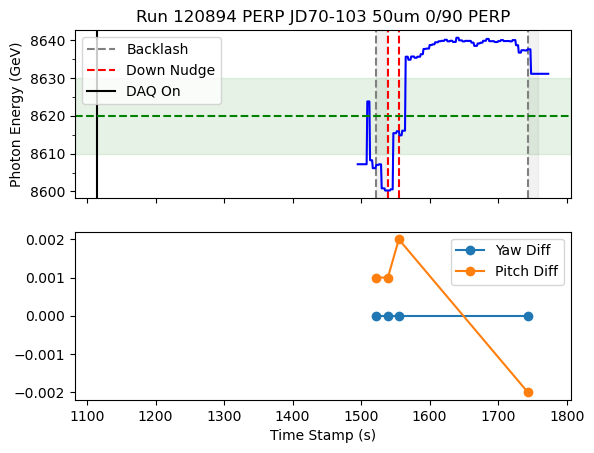

plotting for run  120911
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    30
Undefined                   11
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

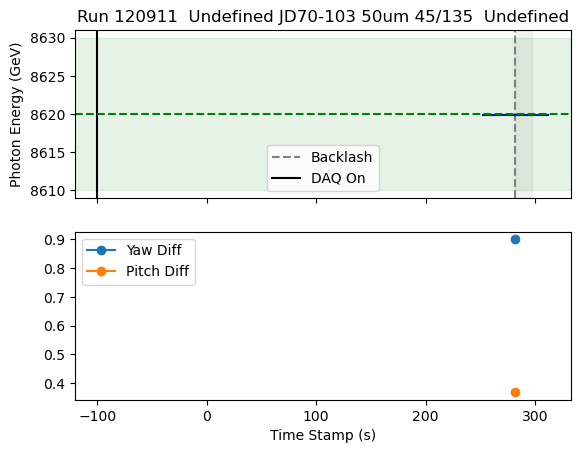

plotting for run  120916
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 45/135 deg    90
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

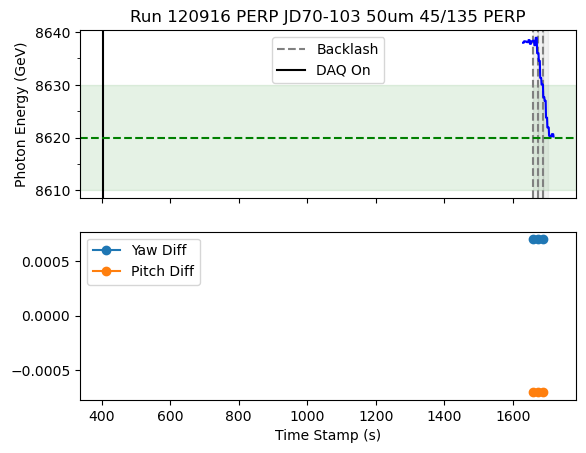

plotting for run  120930
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    36
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

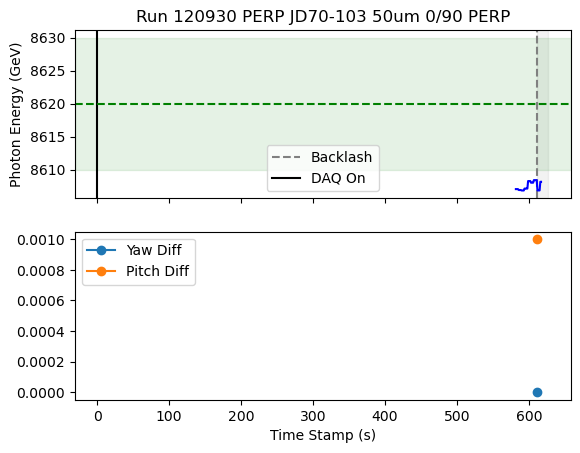

plotting for run  120936
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    217
Undefined                     9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

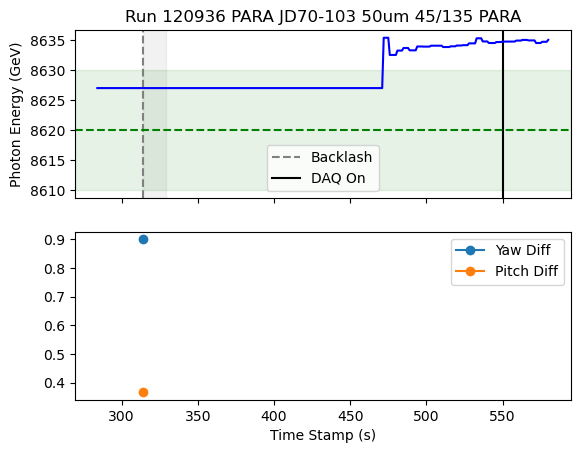

plotting for run  120938
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    61
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

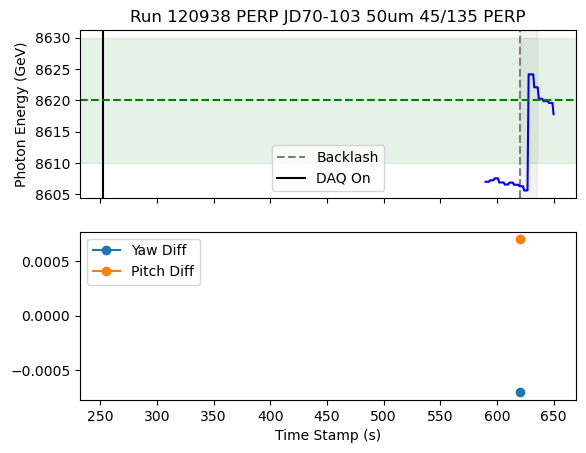

plotting for run  120941
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    61
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

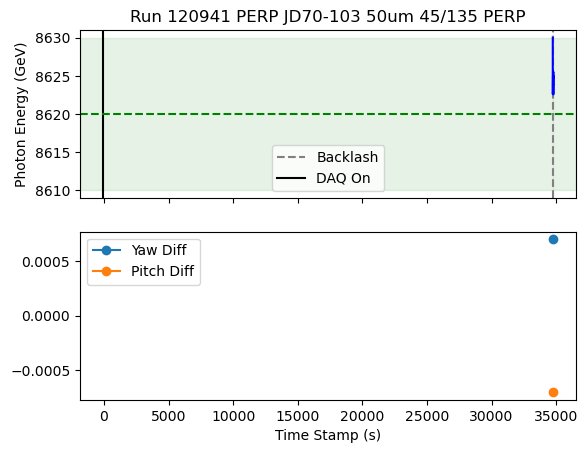

plotting for run  120989
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    161
Undefined                    10
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

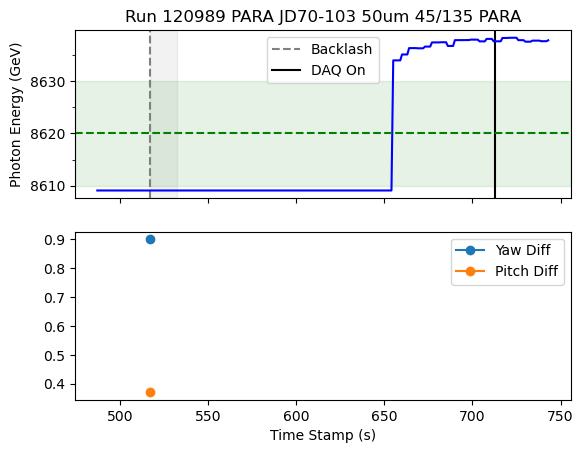

plotting for run  120991
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    56
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

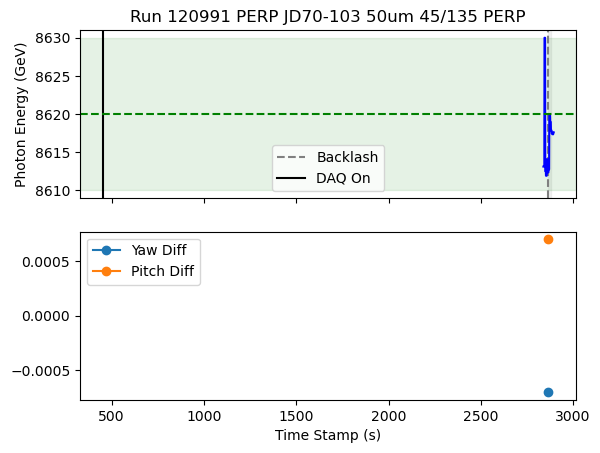

plotting for run  120998
Full nudge sequence is  0    duuddddduuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[11] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
RADIATOR:NAME
JD70-103 50um 0/90 deg    195
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

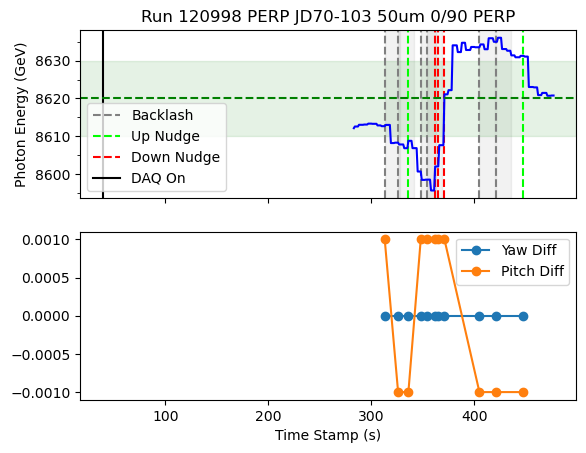

plotting for run  121001
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    29
Undefined                   24
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

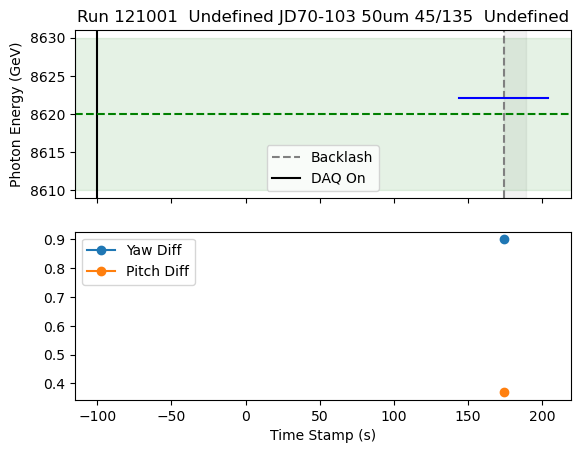

plotting for run  121006
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    53
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

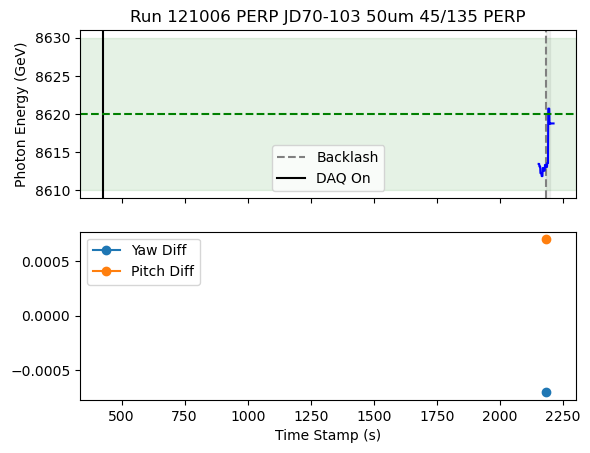

plotting for run  121025
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 0/90 deg    74
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

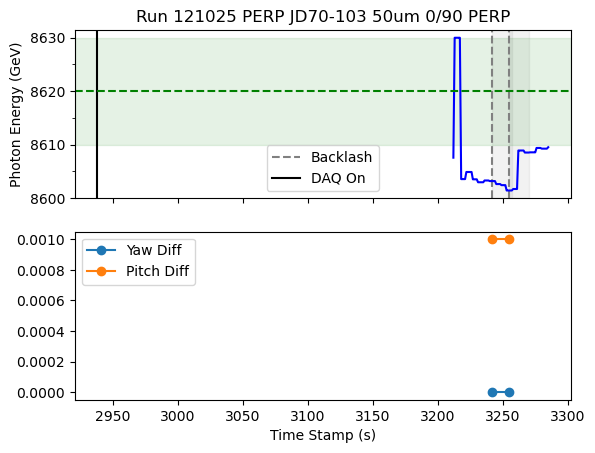

plotting for run  121029
Full nudge sequence is  0    uduuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD70-103 50um 45/135 deg    218
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

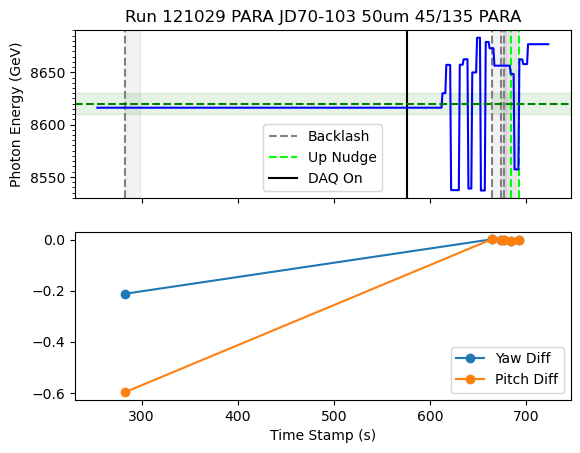

plotting for run  121036
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 0/90 deg    72
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

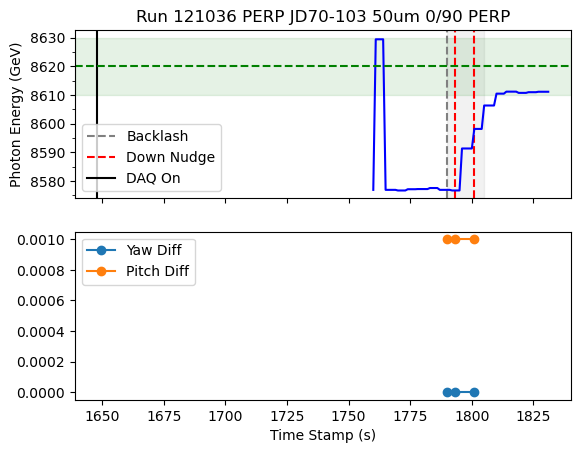

plotting for run  121051
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 0/90 deg    804
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

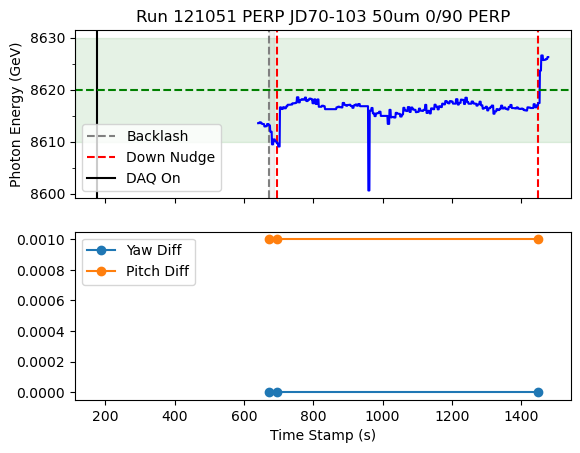

plotting for run  121053
Full nudge sequence is  0    dduuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[7] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
RADIATOR:NAME
JD70-103 50um 45/135 deg    723
Undefined                    11
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

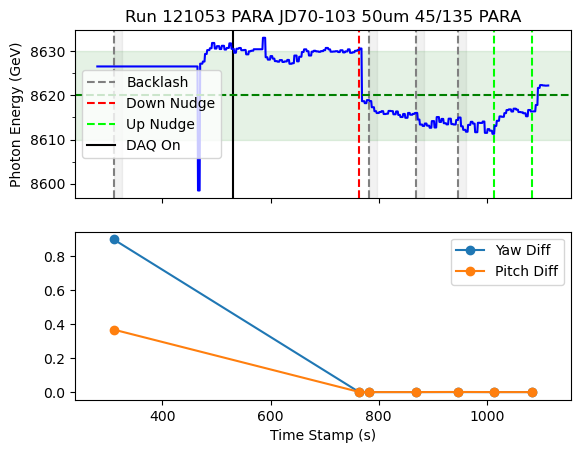

plotting for run  121068
Full nudge sequence is  0    dddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD70-103 50um 0/90 deg    75
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

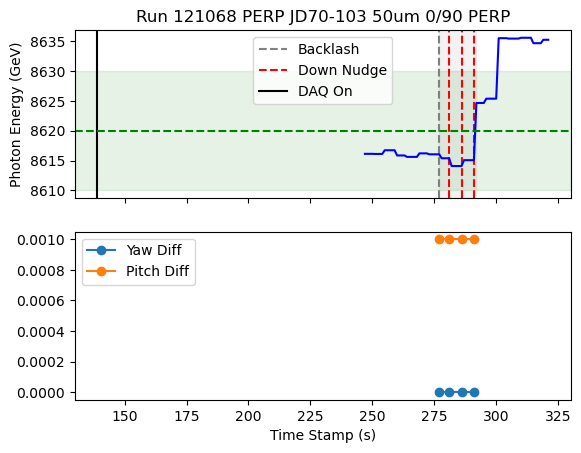

plotting for run  121070
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    56
Undefined                    5
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

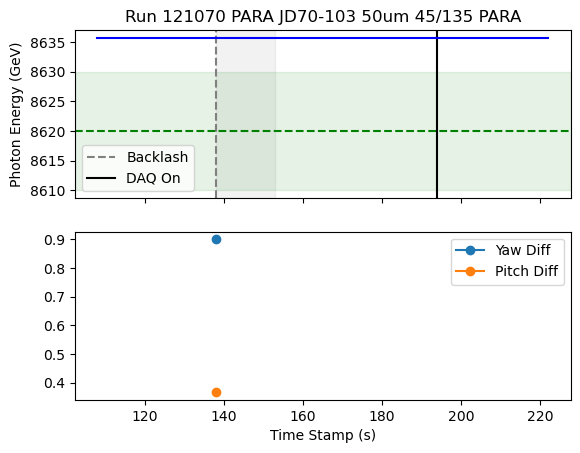

plotting for run  121084
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 0/90 deg    163
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

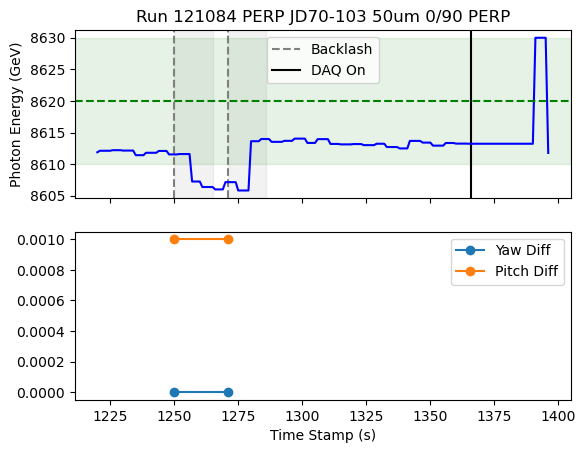

plotting for run  121086
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    156
Undefined                    20
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

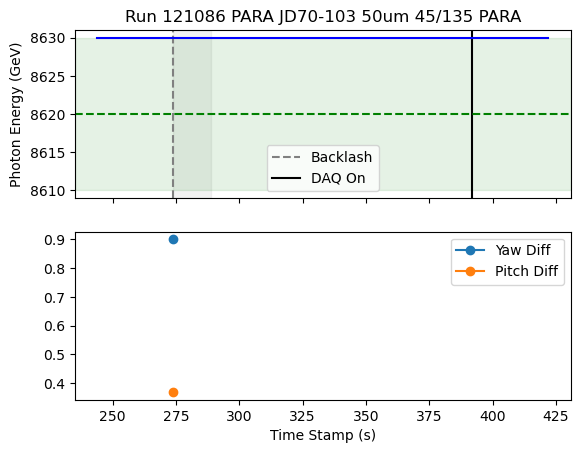

plotting for run  121097
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 0/90 deg    346
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

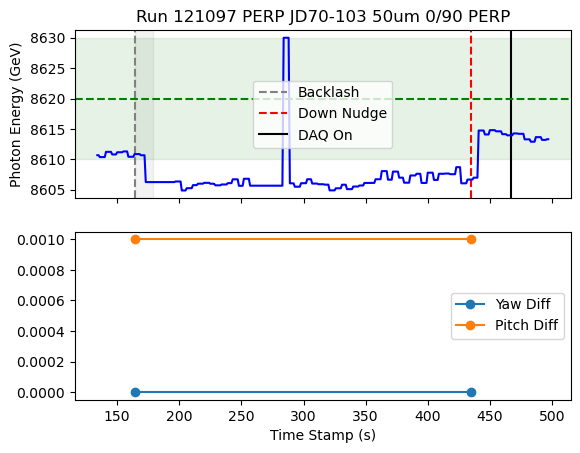

plotting for run  121099
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 45/135 deg    273
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

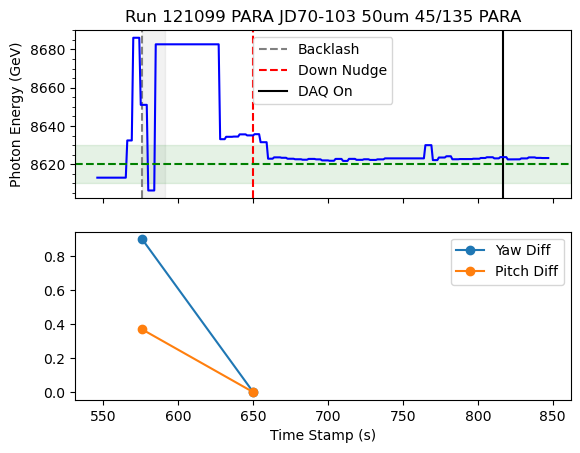

plotting for run  121102
Full nudge sequence is  0    uuuuuddddduuuuuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[21] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
RADIATOR:NAME
JD70-103 50um 45/135 deg    1582
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

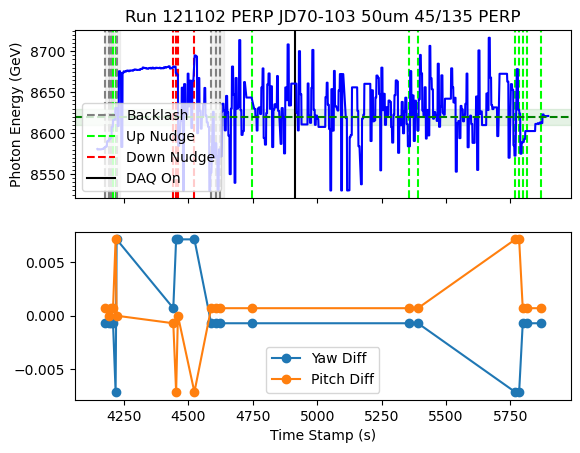

plotting for run  121130
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    309
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

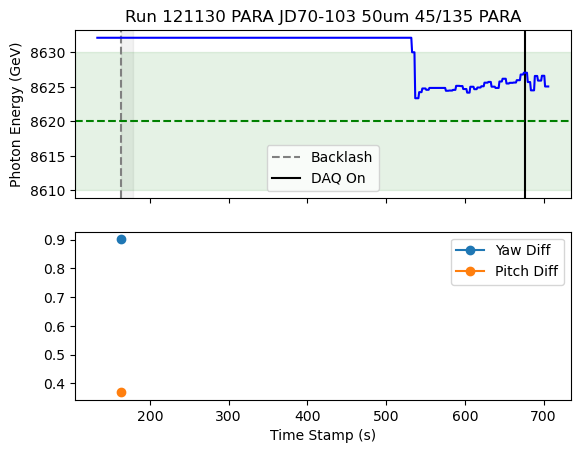

plotting for run  121132
Full nudge sequence is  0    dddduuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[7] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
RADIATOR:NAME
JD70-103 50um 45/135 deg    278
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

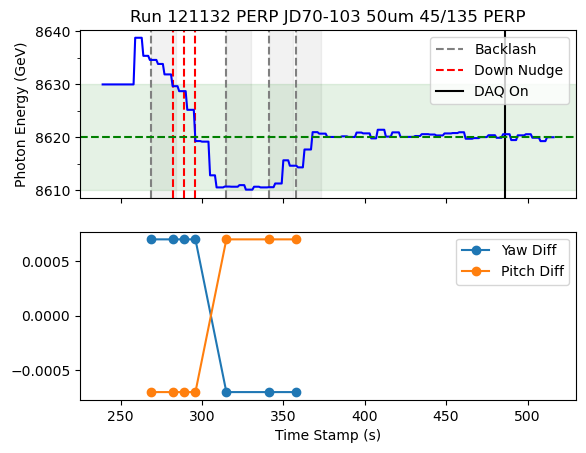

plotting for run  121137
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    4431
BLANK                     1727
Undefined                  140
4.5x10-4 Al 40um            35
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

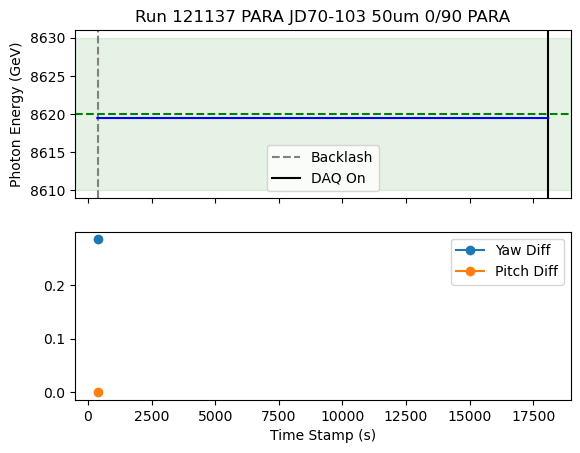

plotting for run  121143
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    291
Undefined                     9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

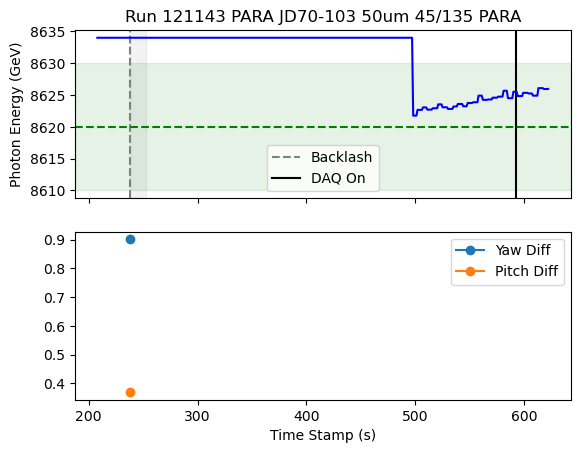

plotting for run  121148
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 121148
plotting for run  121157
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    176
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

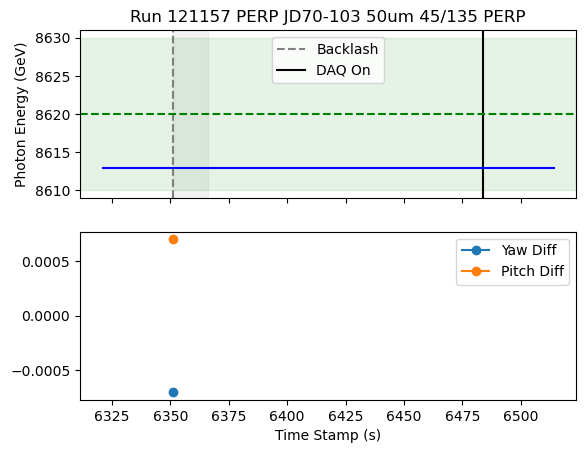

plotting for run  121160
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    152
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

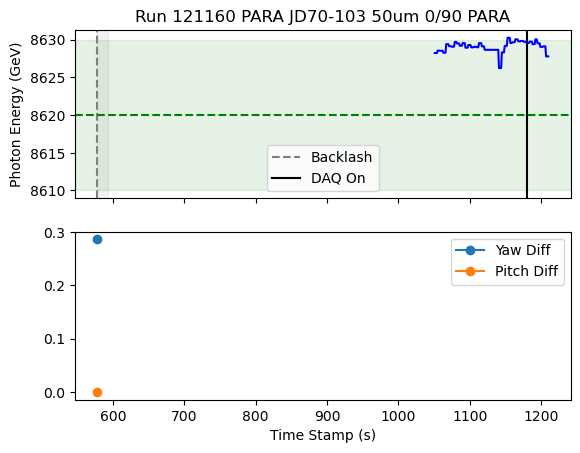

plotting for run  121169
Full nudge sequence is  0    uuuuuuuuddddddddddduuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[23] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
RADIATOR:NAME
JD70-103 50um 0/90 deg    805
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

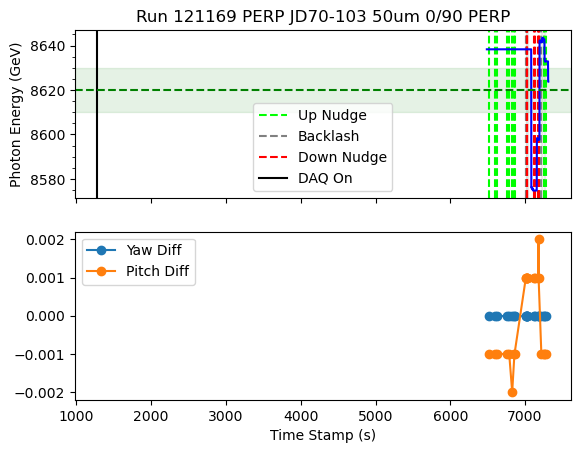

plotting for run  121171
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    200
Undefined                     1
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

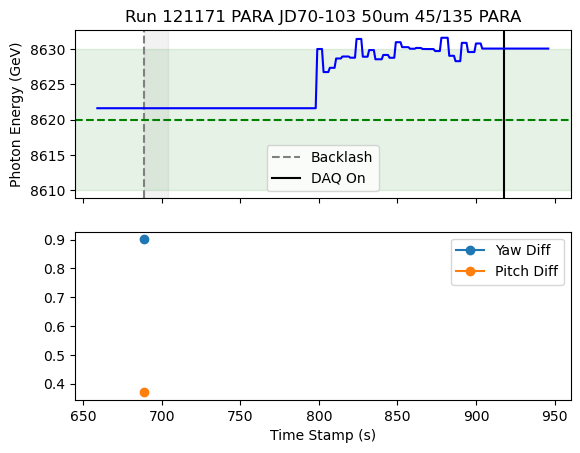

plotting for run  121174
Full nudge sequence is  0    dddu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD70-103 50um 45/135 deg    1206
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

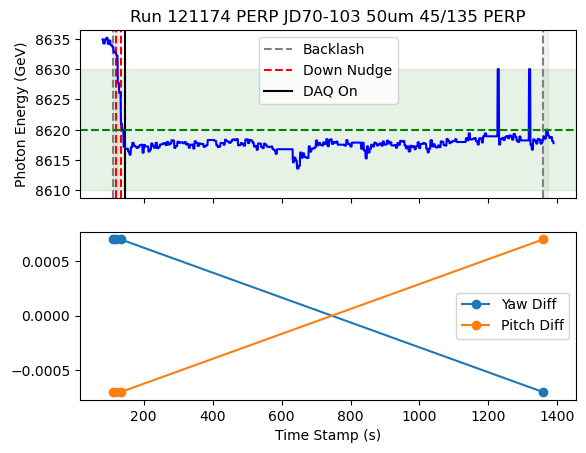

plotting for run  121182
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 0/90 deg    181
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

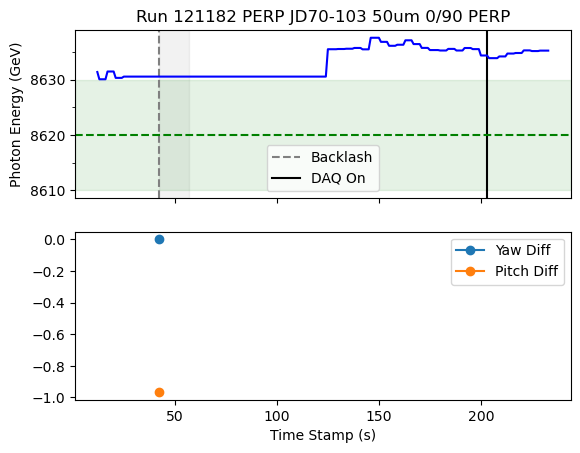

plotting for run  121185
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    4391
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

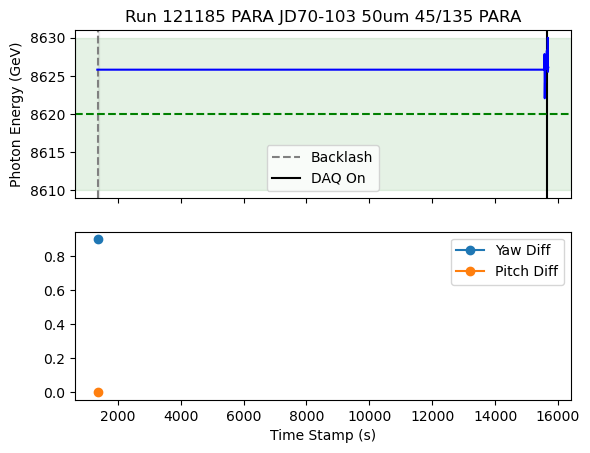

plotting for run  121187
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD70-103 50um 45/135 deg    153
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

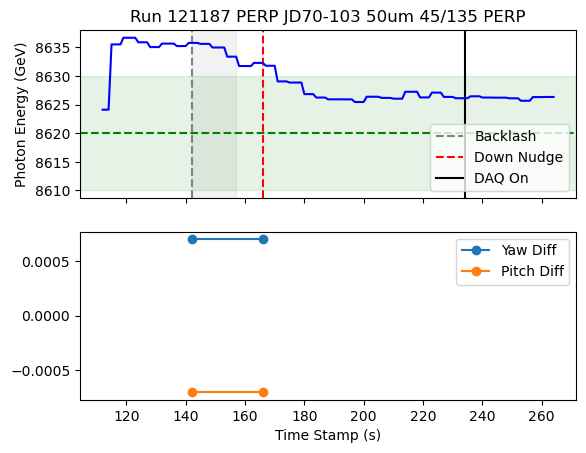

plotting for run  121203
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD70-103 50um 45/135 deg    522
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

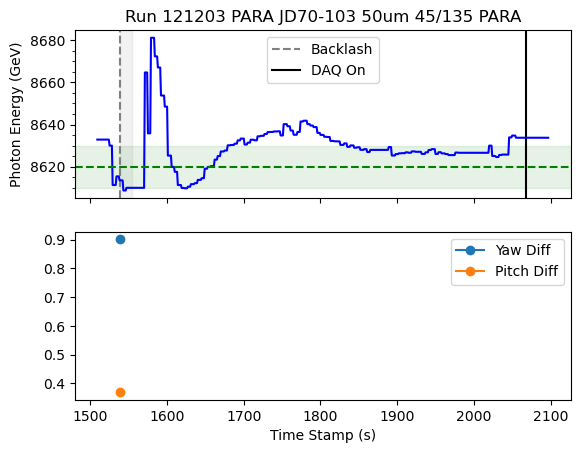

plotting for run  121205
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD70-103 50um 45/135 deg    172
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

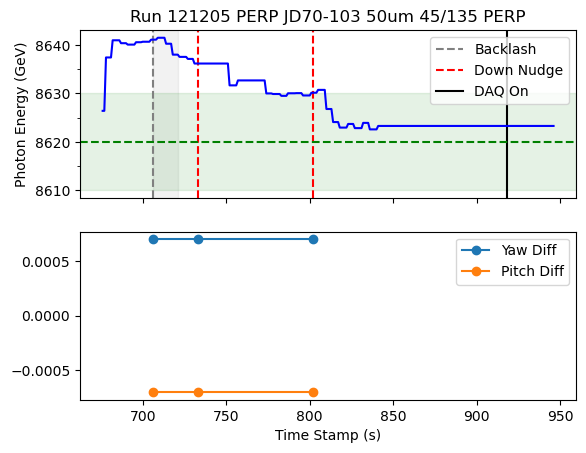

<Figure size 640x480 with 0 Axes>

In [9]:
for runNum in backlash_runs_2023:
    plot_run(df_2023_good,runNum)

plotting for run  131407
Full nudge sequence is  0    duuddddduuuuuuuuuuuuduudddddduuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[33] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
seq val is  30
seq val is  31
seq val is  32
seq val is  33
RADIATOR:NAME
JD80-212 80um 45/135 deg    1281
Undefined                    287
Name: count, dtype: int64


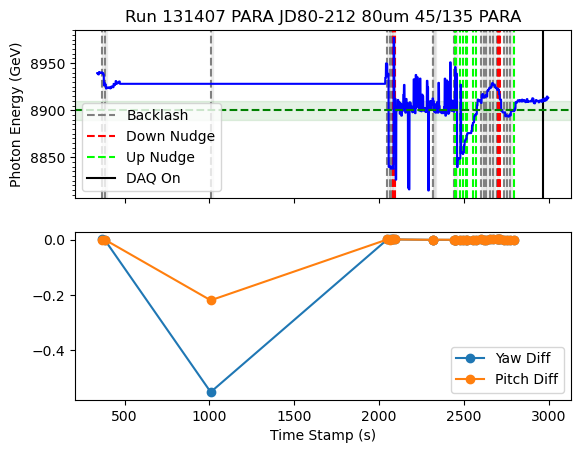

plotting for run  131409
Full nudge sequence is  0    uddddddddddu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[12] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
RADIATOR:NAME
JD80-212 80um 45/135 deg    412
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

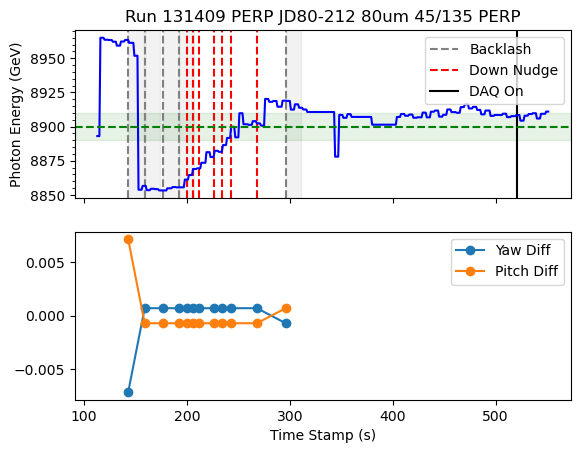

plotting for run  131416
Full nudge sequence is  0    uuuuuuddduuddduuddddddudduudd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[29] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
RADIATOR:NAME
JD80-212 80um 0/90 deg    5831
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

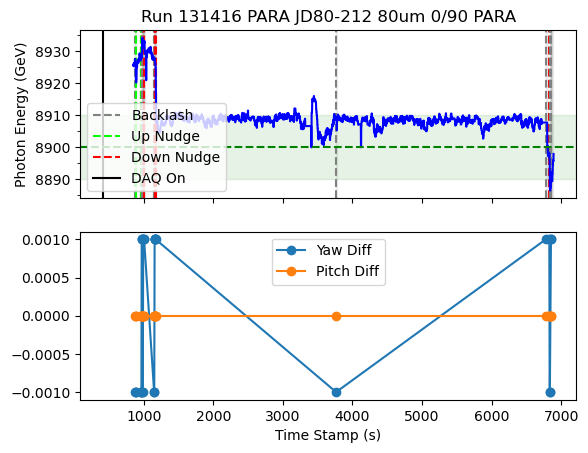

plotting for run  131422
Full nudge sequence is  0    dddddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 45/135 deg    1264
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

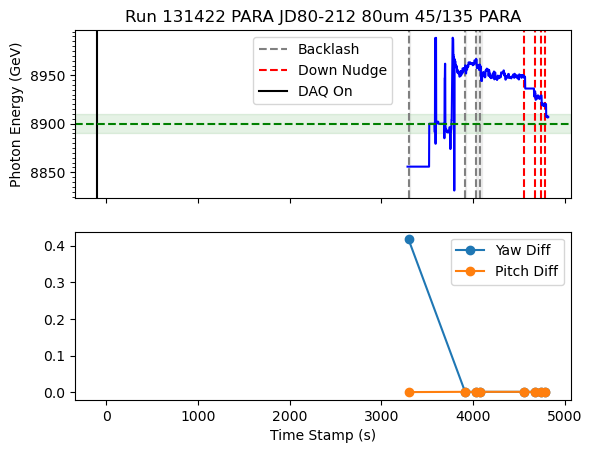

plotting for run  131429
Full nudge sequence is  0    uuuuuddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 45/135 deg    433
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

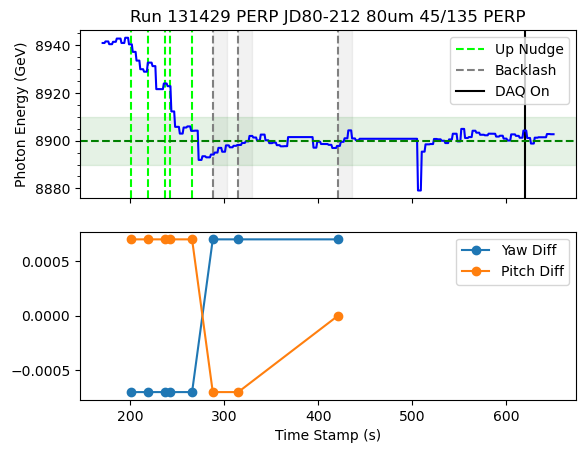

plotting for run  131438
Full nudge sequence is  0    ddddduuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[13] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
RADIATOR:NAME
JD80-212 80um 0/90 deg    281
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

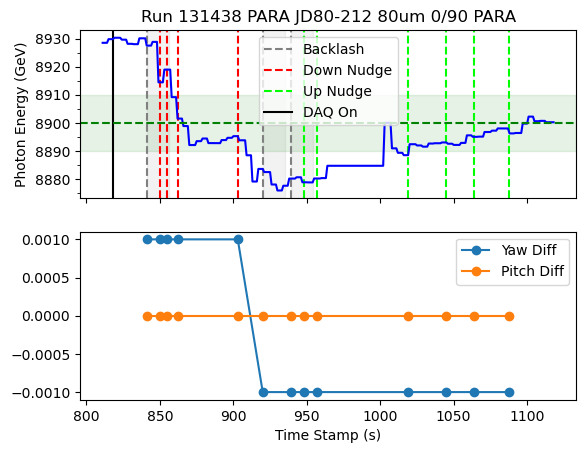

plotting for run  131443
Full nudge sequence is  0    dddddduuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD80-212 80um 0/90 deg    345
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

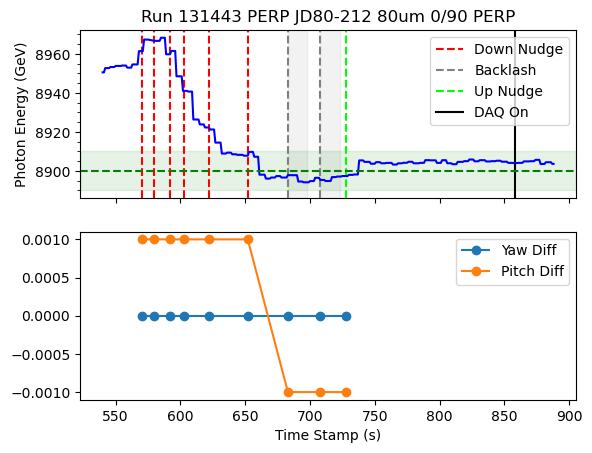

plotting for run  131447
Full nudge sequence is  0    ddudddddddddduuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[20] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
RADIATOR:NAME
JD80-212 80um 45/135 deg    1514
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

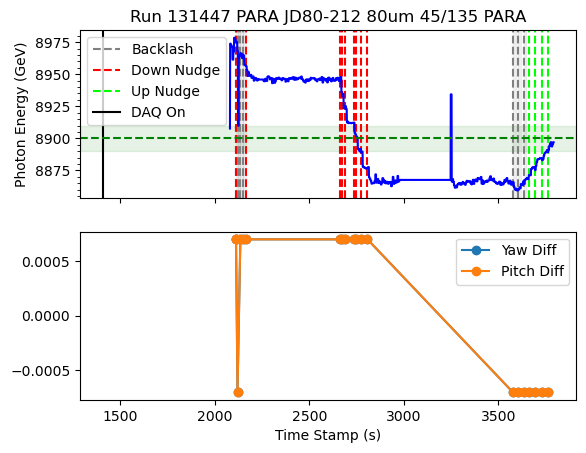

plotting for run  131449
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131449
plotting for run  131456
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    413
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

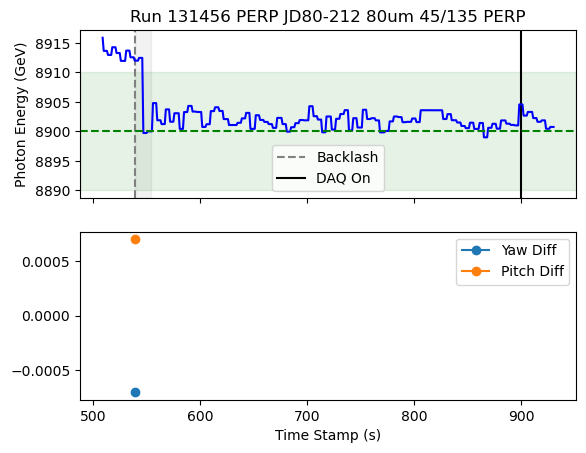

plotting for run  131488
Full nudge sequence is  0    dddddddddddddddddddddddddddduddddddddddddddddd...
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddddddddddddddddddddddddddddddddddddddddd...
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddddddddddddddddddddddddddddddddddddddddddddd...
Name: NudgeSequenceReduced_Correct, dtype: object
[61] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
seq val is  30
seq val is  31
seq val is  32
seq val is  33
seq val is  34
seq val is  35
seq val is  36
seq val is  37
seq val is  38
seq v

<Figure size 640x480 with 0 Axes>

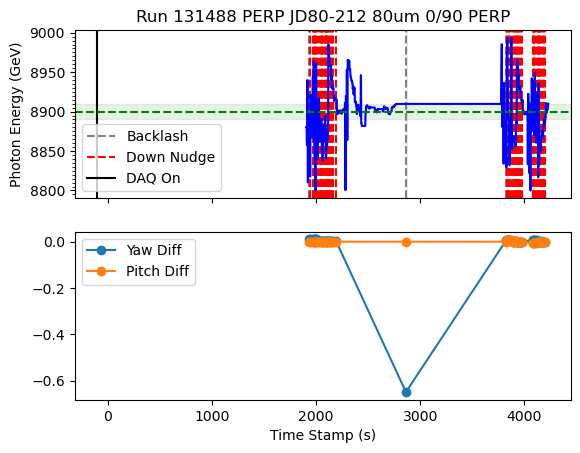

plotting for run  131491
Full nudge sequence is  0    uuuuuddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 0/90 deg    506
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

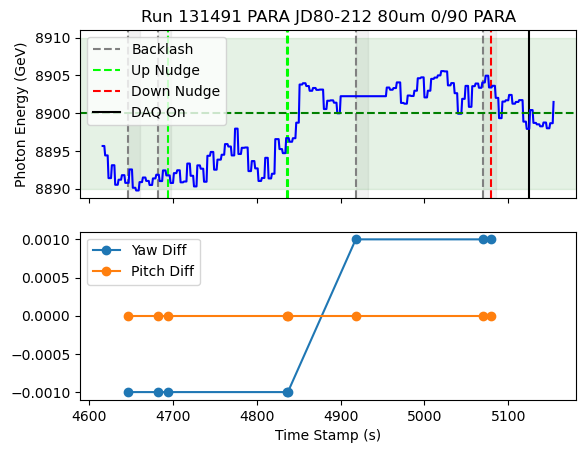

plotting for run  131581
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131581
plotting for run  131600
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 0/90 deg    61
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

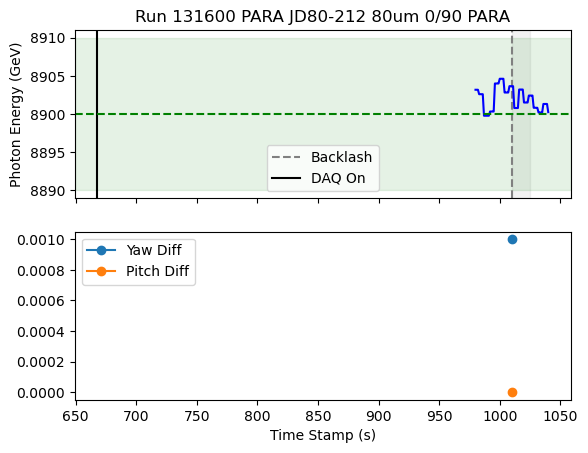

plotting for run  131602
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    79
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

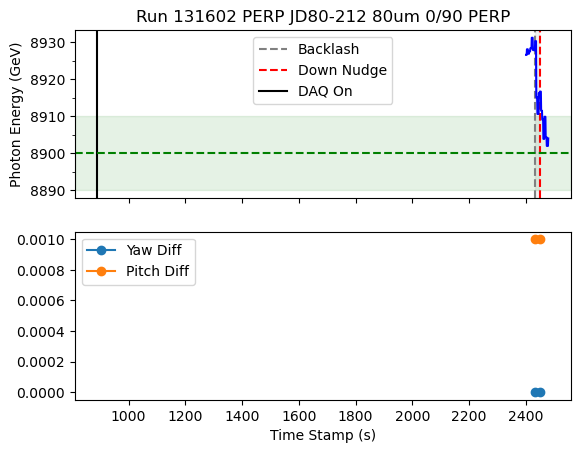

plotting for run  131620
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    101
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

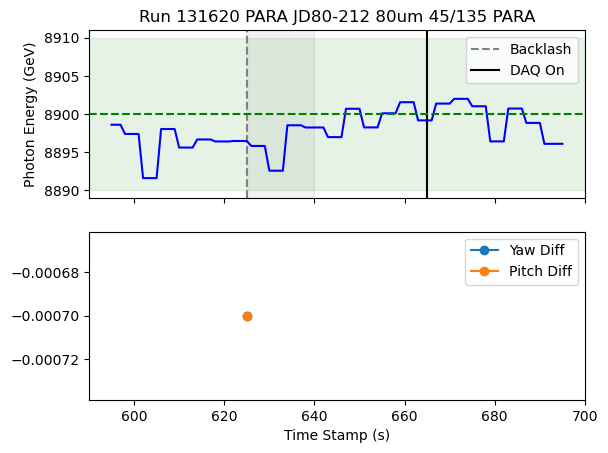

plotting for run  131622
Full nudge sequence is  0    uuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    239
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

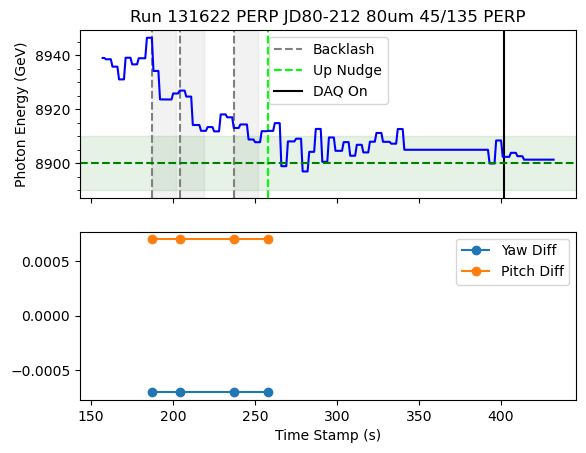

plotting for run  131634
Full nudge sequence is  0    uuuuuuud
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 0/90 deg    213
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

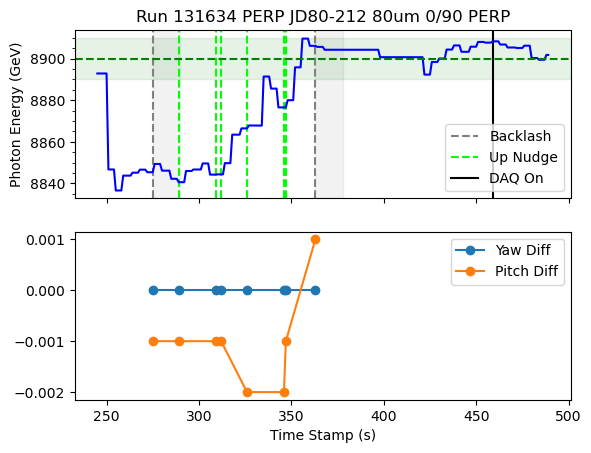

plotting for run  131658
Full nudge sequence is  0    uu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 45/135 deg    366
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

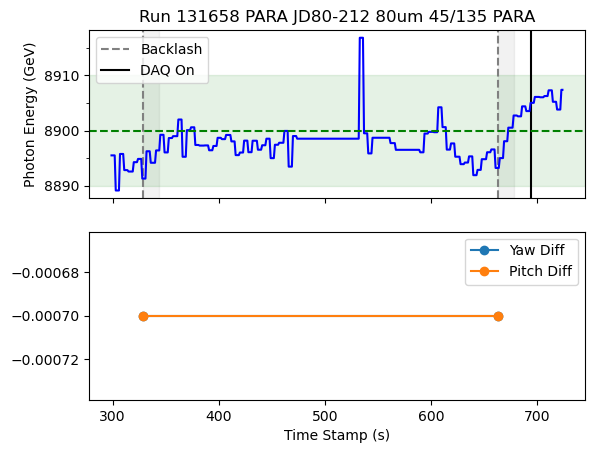

plotting for run  131662
Full nudge sequence is  0    uuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD80-212 80um 45/135 deg    136
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

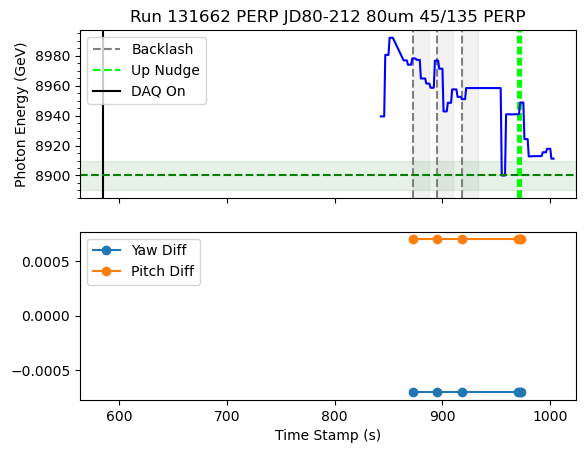

plotting for run  131672
Full nudge sequence is  0    ddddddddduuuuuuuuduuuuuuuuuuuuddddddddddduuuuu...
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[59] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
seq val is  30
seq val is  31
seq val is  32
seq val is  33
seq val is  34
seq val is  35
seq val is  36
seq val is  37
seq val is  38
seq val is  39
seq val is  40
seq val is  41
seq val is  42
seq val is  43
seq val is  44
se

<Figure size 640x480 with 0 Axes>

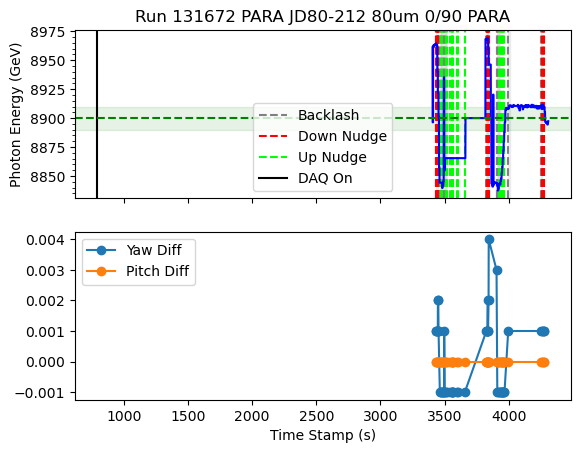

plotting for run  131703
Full nudge sequence is  0    dddddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 45/135 deg    140
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

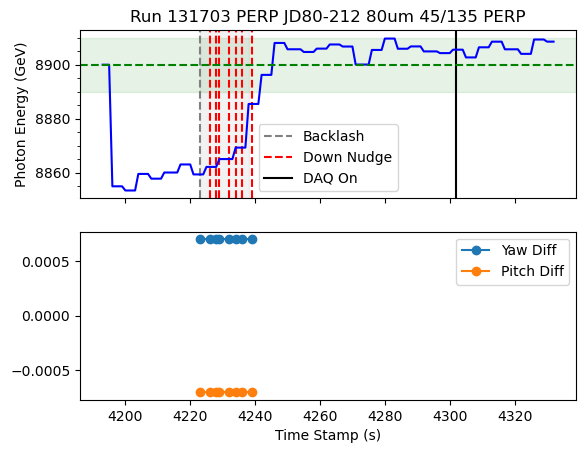

plotting for run  131706
Full nudge sequence is  0    ddddddddduuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[15] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
RADIATOR:NAME
JD80-212 80um 0/90 deg    151
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

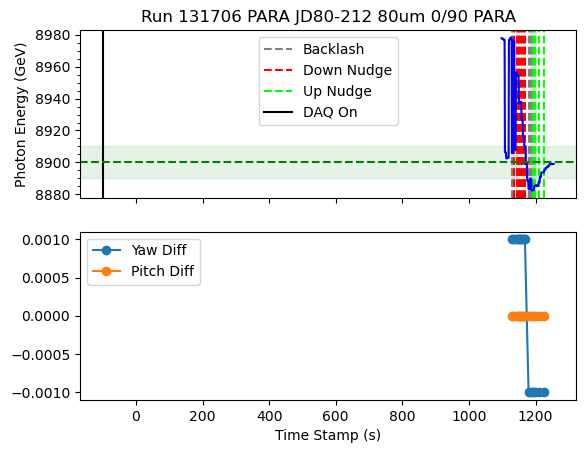

plotting for run  131709
Full nudge sequence is  0    ddduuuudd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD80-212 80um 0/90 deg    274
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

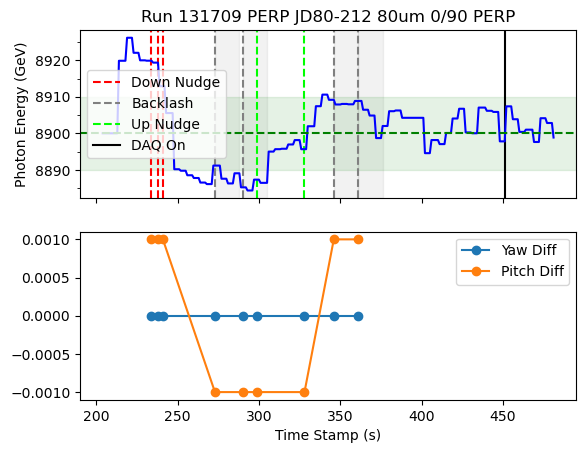

plotting for run  131714
Full nudge sequence is  0    dddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    209
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

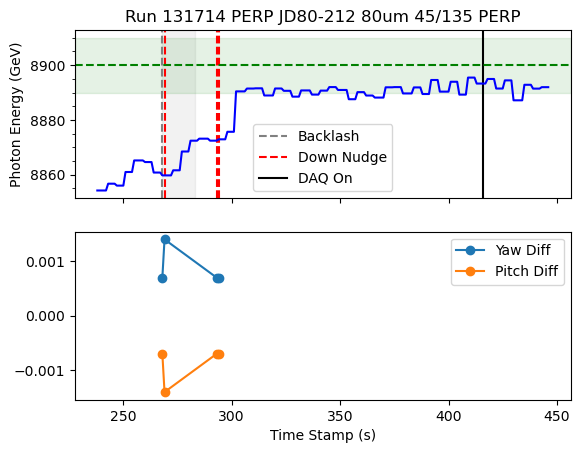

plotting for run  131719
Full nudge sequence is  0    ddddddddduudddduuudddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[22] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
RADIATOR:NAME
JD80-212 80um 0/90 deg    206
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

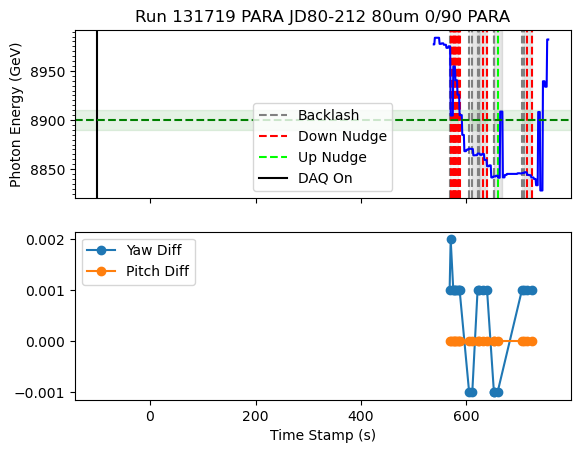

plotting for run  131720
Full nudge sequence is  0    uuuuuuuuuuuud
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[13] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
RADIATOR:NAME
JD80-212 80um 0/90 deg    2080
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

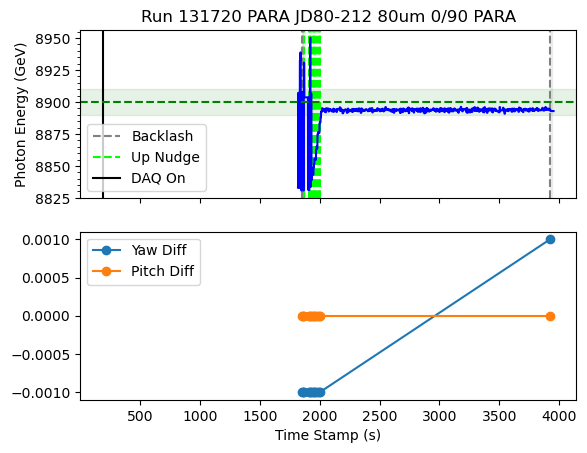

plotting for run  131726
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    67
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

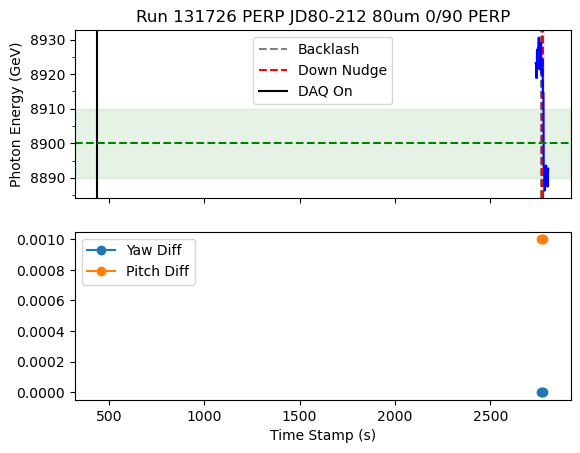

plotting for run  131733
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131733
plotting for run  131734
Full nudge sequence is  0    ddddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[7] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
RADIATOR:NAME
JD80-212 80um 45/135 deg    119
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

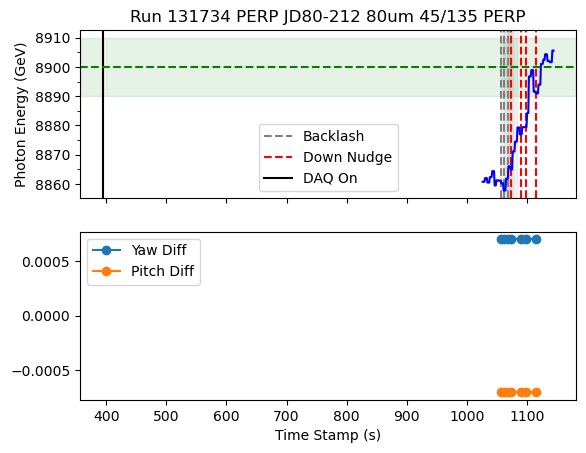

plotting for run  131744
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 0/90 deg    107
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

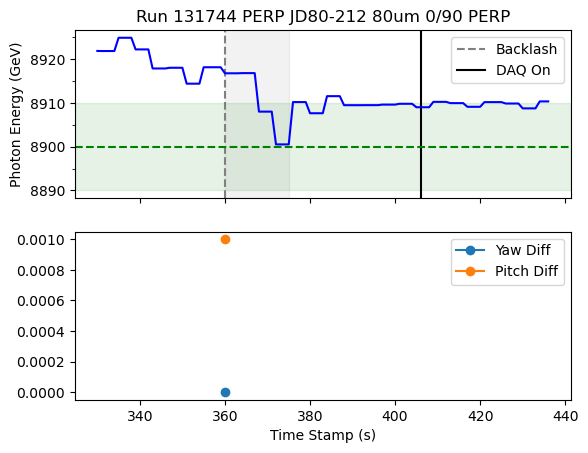

plotting for run  131749
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    159
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

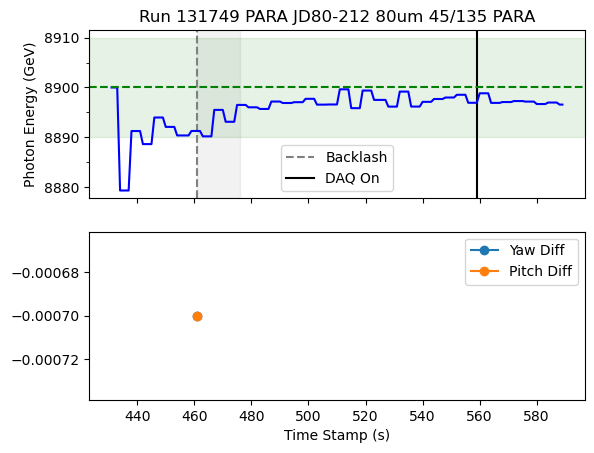

plotting for run  131751
Full nudge sequence is  0    uuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    213
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

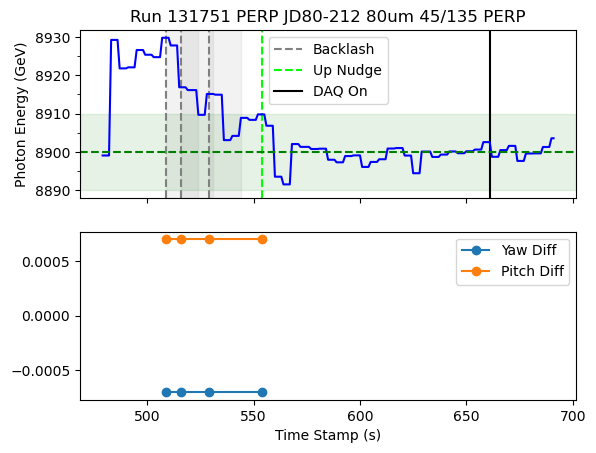

plotting for run  131771
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    705
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

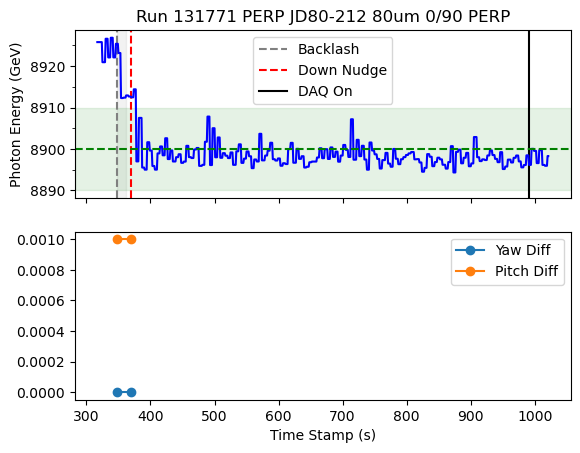

plotting for run  131774
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    183
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

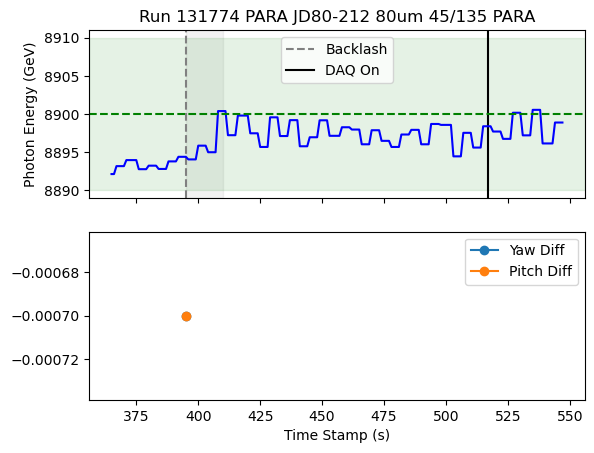

plotting for run  131777
Full nudge sequence is  0    uuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    158
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

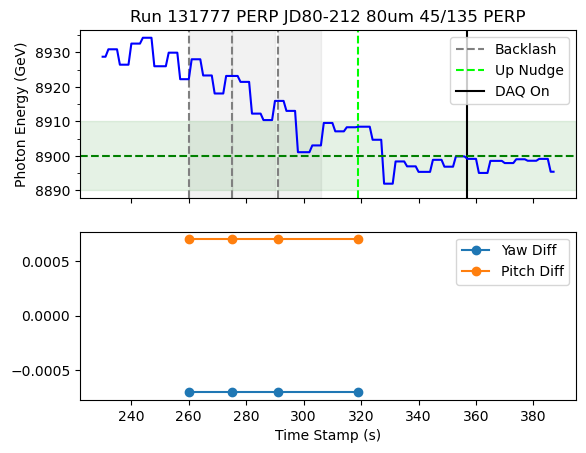

plotting for run  131801
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    133
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

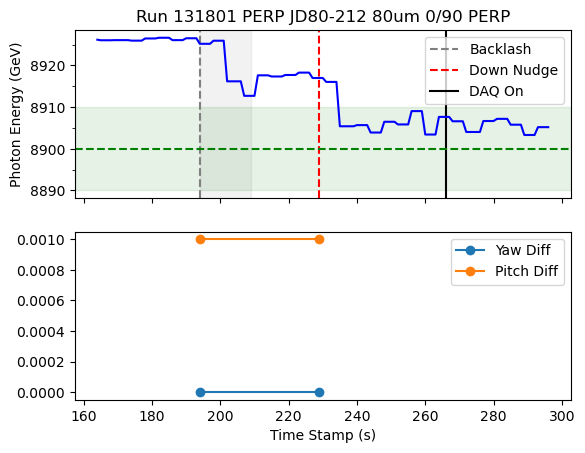

plotting for run  131807
Full nudge sequence is  0    uuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD80-212 80um 45/135 deg    139
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

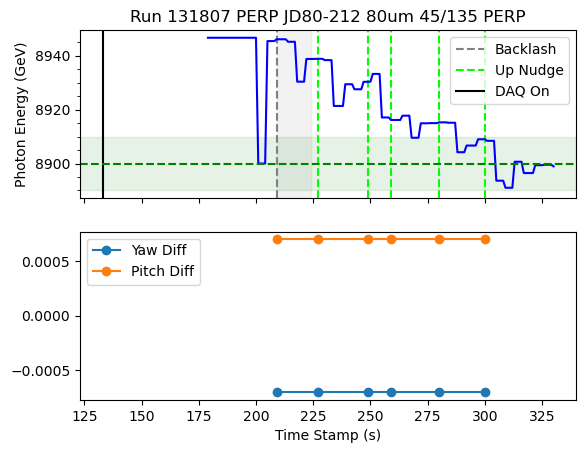

plotting for run  131816
Full nudge sequence is  0    uuuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD80-212 80um 0/90 deg    591
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

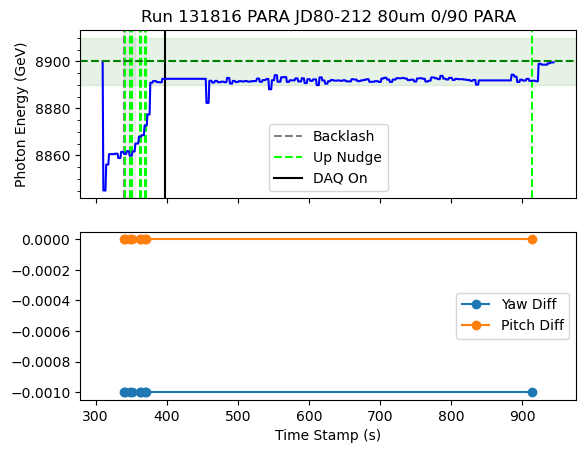

plotting for run  131825
Full nudge sequence is  0    duuuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[10] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
RADIATOR:NAME
JD80-212 80um 45/135 deg    318
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

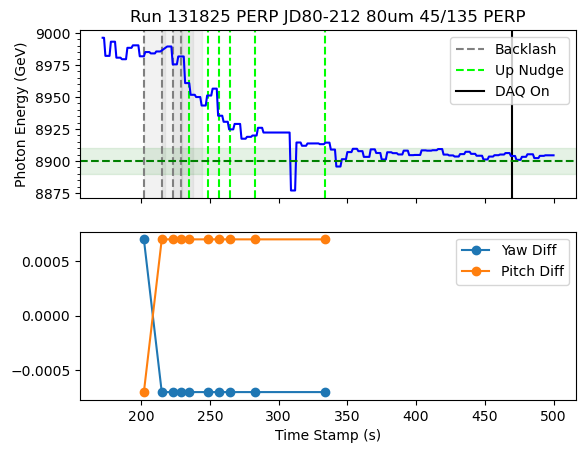

plotting for run  131829
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    97
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

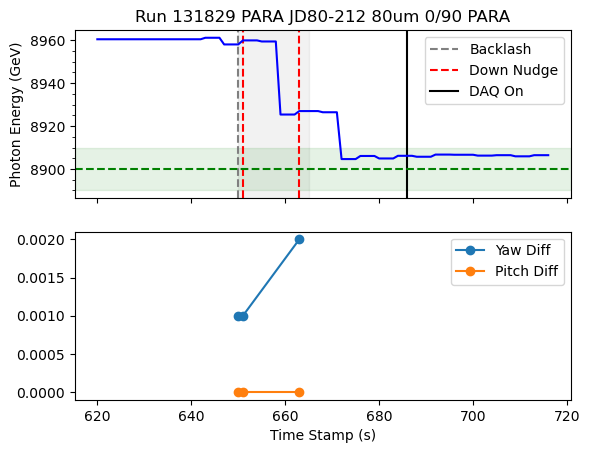

plotting for run  131835
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131835
plotting for run  131840
Full nudge sequence is  0    uu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 45/135 deg    225
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

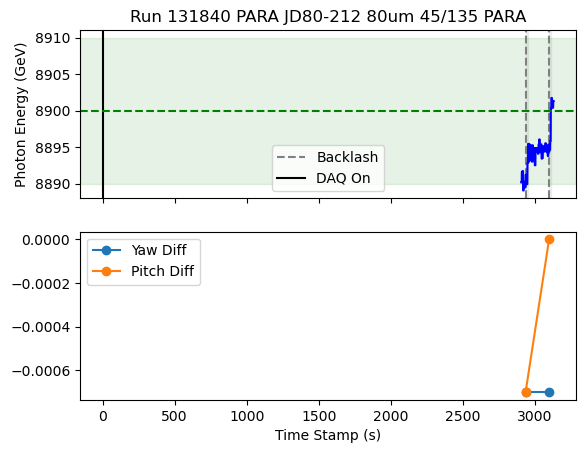

plotting for run  131863
Full nudge sequence is  0    ddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 45/135 deg    325
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

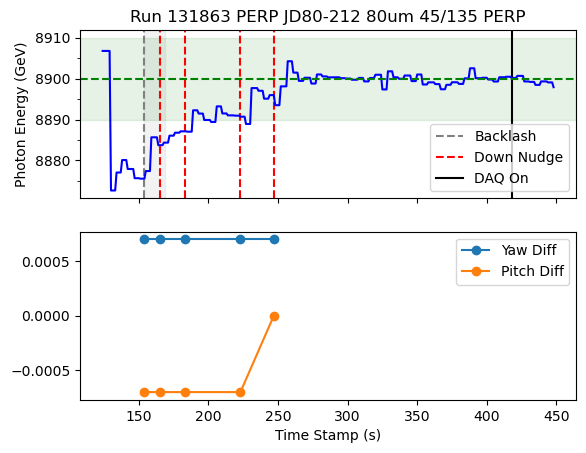

plotting for run  131874
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    128
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

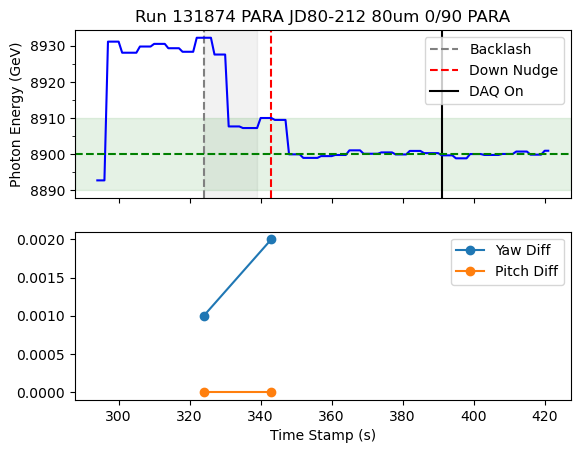

plotting for run  131881
Full nudge sequence is  0    dduu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 0/90 deg    100
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

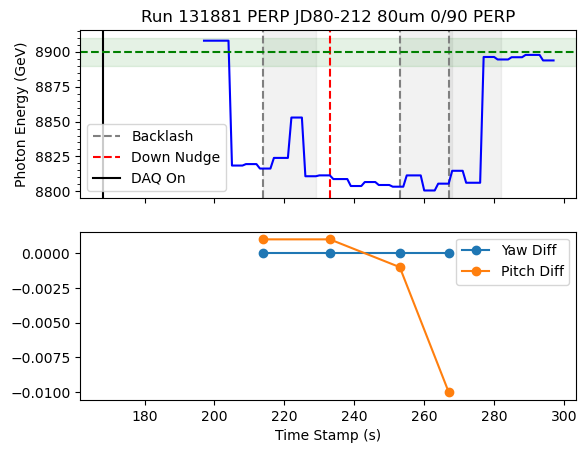

plotting for run  131887
Full nudge sequence is  0    dddddddddduu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[12] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
RADIATOR:NAME
JD80-212 80um 45/135 deg    107
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

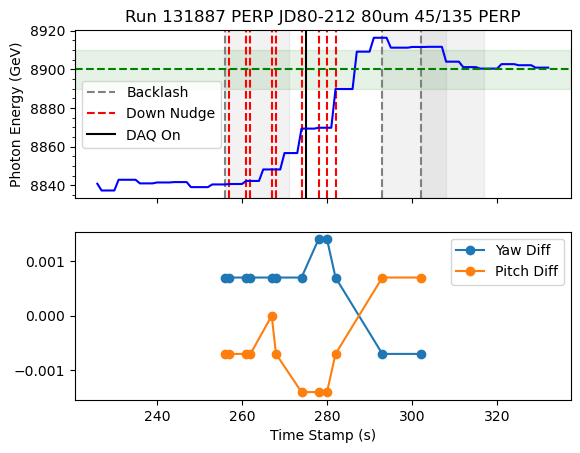

plotting for run  131890
Full nudge sequence is  0    uddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 0/90 deg    204
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

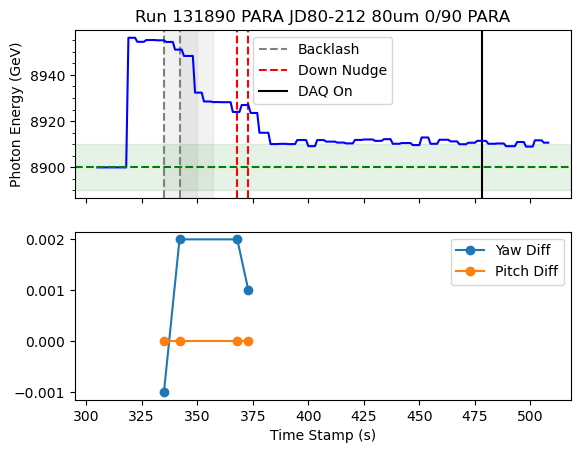

plotting for run  131892
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131892
plotting for run  131894
Full nudge sequence is  0    uu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    93
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

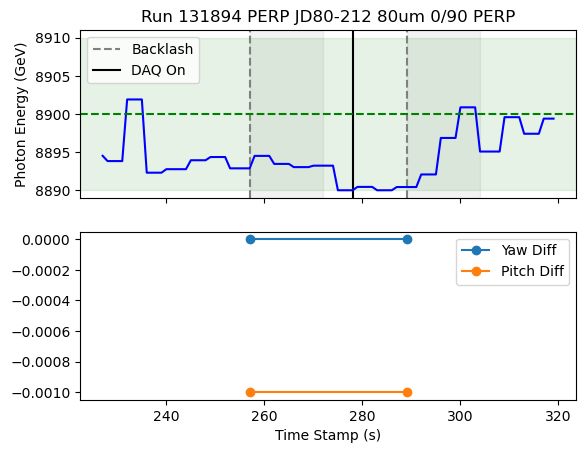

plotting for run  131904
Full nudge sequence is  0    ddddudddddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[13] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
RADIATOR:NAME
JD80-212 80um 45/135 deg    239
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

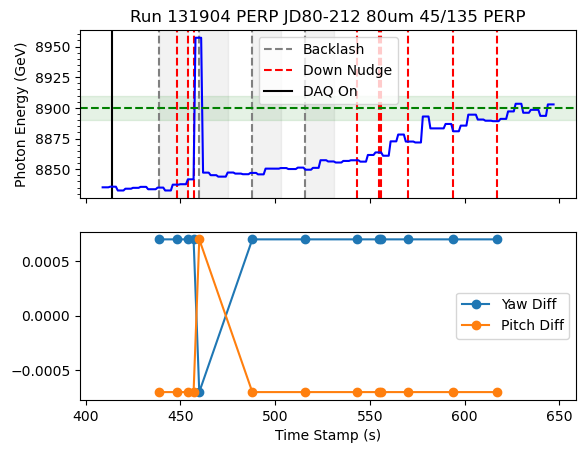

plotting for run  131908
Full nudge sequence is  0    dddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddd
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 0/90 deg    205
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

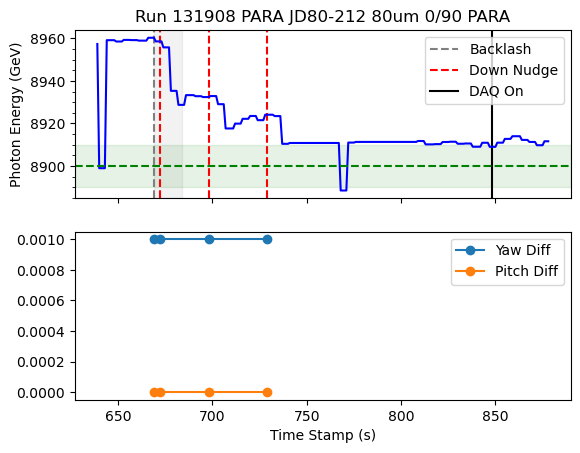

plotting for run  131918
Full nudge sequence is  0    uuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    188
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

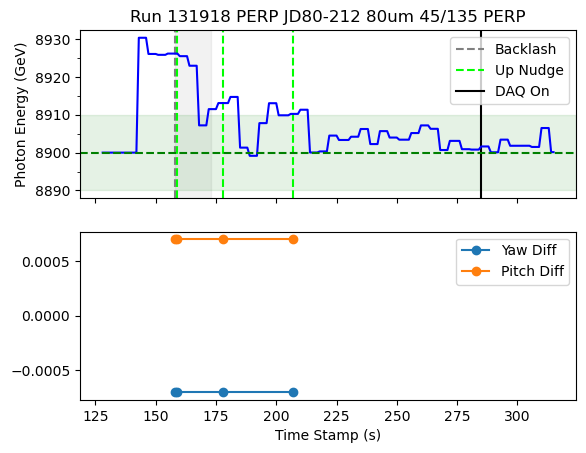

plotting for run  131921
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 45/135 deg    103
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

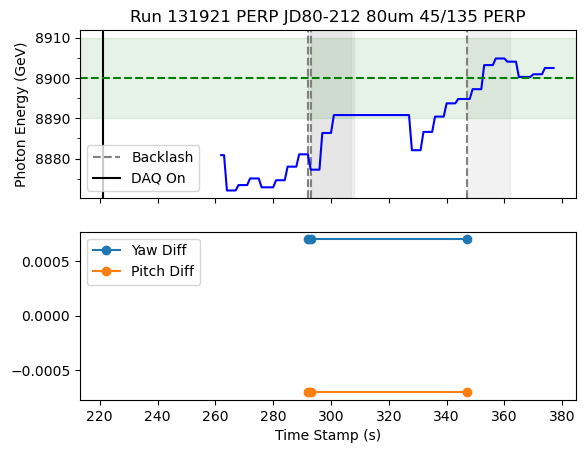

plotting for run  131925
Full nudge sequence is  0    ddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 0/90 deg    65
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

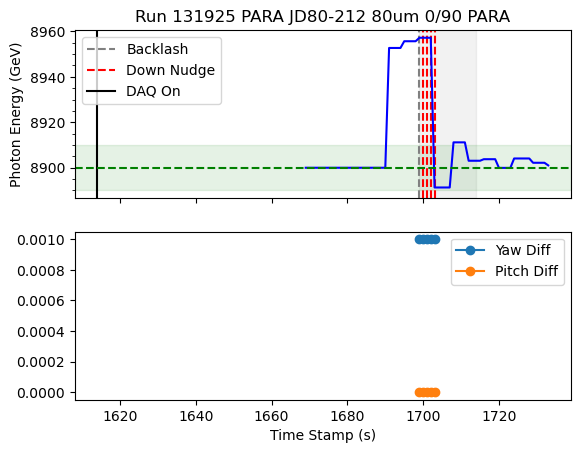

plotting for run  131932
Full nudge sequence is  0    duuuuuuud
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD80-212 80um 45/135 deg    204
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

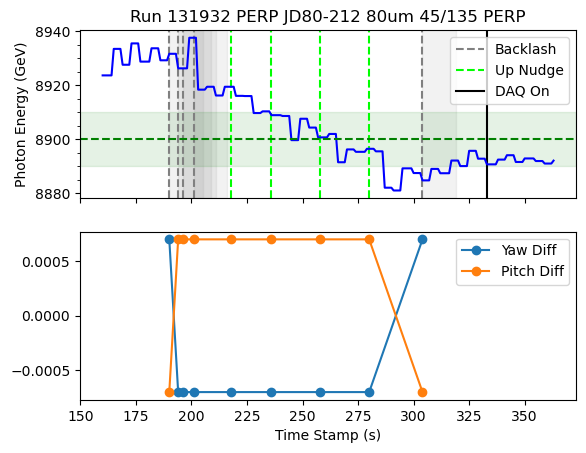

plotting for run  131937
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 0/90 deg    78
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

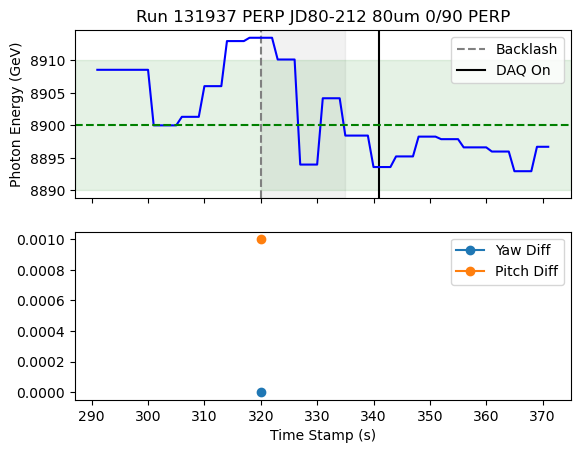

plotting for run  131946
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131946
plotting for run  131953
Full nudge sequence is  0    dddduuuuuuuuudddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[17] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
RADIATOR:NAME
JD80-212 80um 0/90 deg    277
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

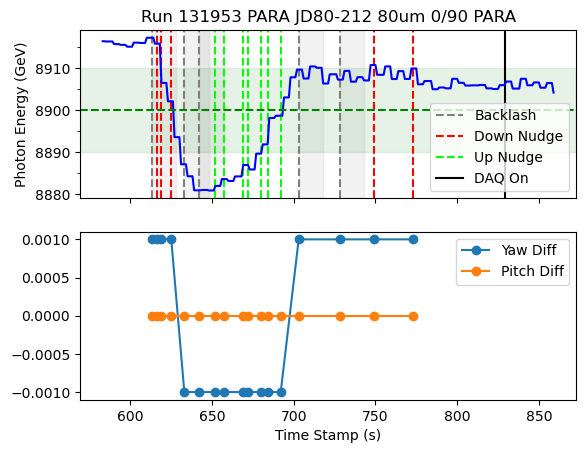

plotting for run  131955
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    31
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

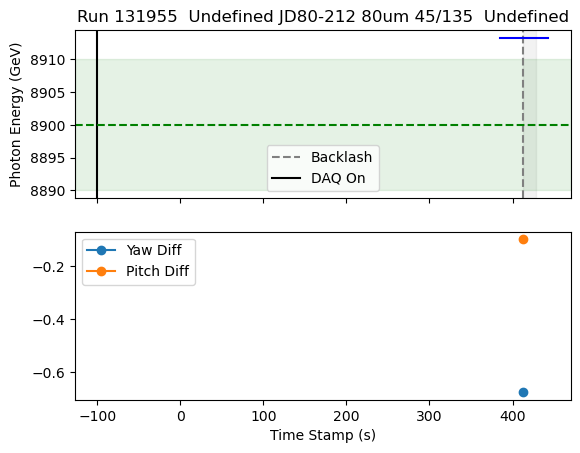

plotting for run  131956
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 0/90 deg    20
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

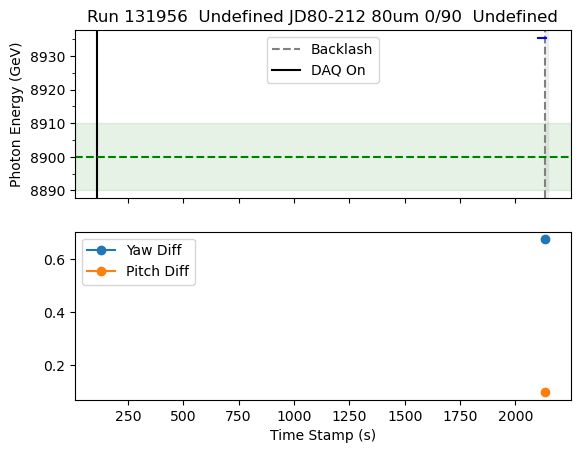

plotting for run  131964
Full nudge sequence is  0    uuddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 0/90 deg    78
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

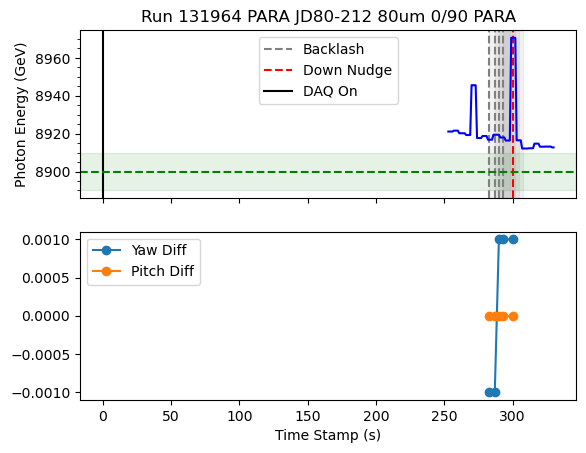

plotting for run  131968
Full nudge sequence is  0    dduuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 0/90 deg    292
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

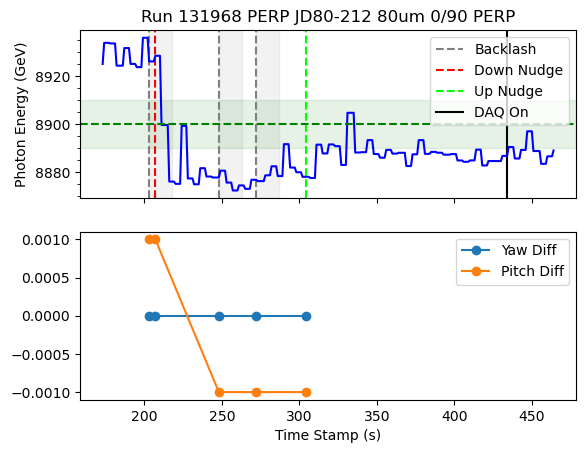

plotting for run  131974
Full nudge sequence is  0    udddddddu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[9] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
RADIATOR:NAME
JD80-212 80um 45/135 deg    242
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

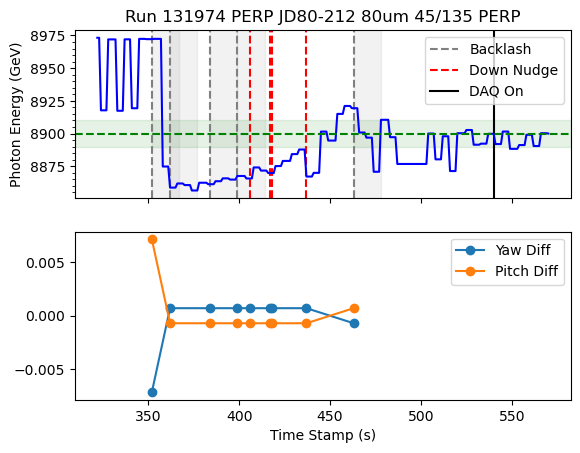

plotting for run  131991
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 131991
plotting for run  131996
Full nudge sequence is  0    uuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 0/90 deg    323
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

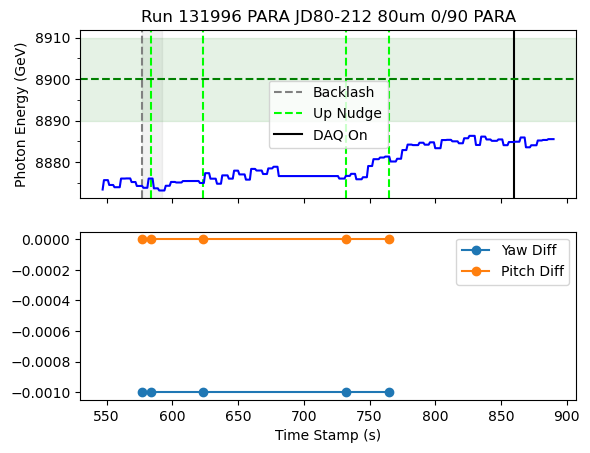

plotting for run  132001
Full nudge sequence is  0    d
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    d
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    167
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

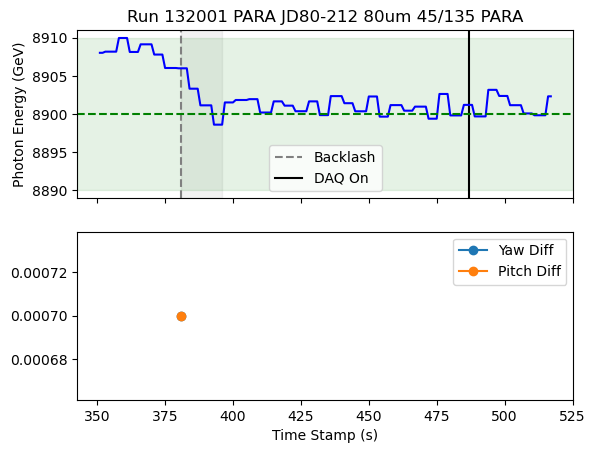

plotting for run  132003
Full nudge sequence is  0    uu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 45/135 deg    142
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

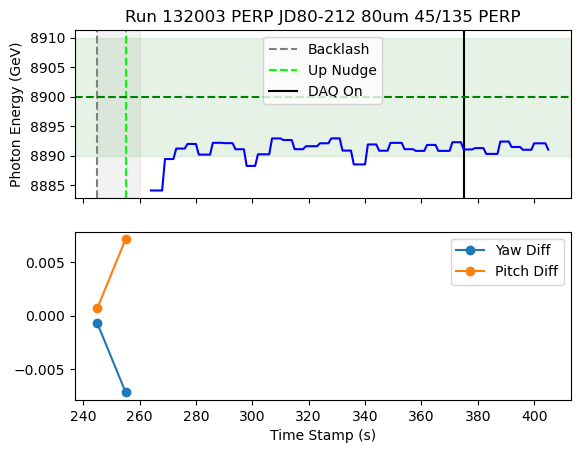

plotting for run  132004
Full nudge sequence is  0    duuuuuud
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[8] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
RADIATOR:NAME
JD80-212 80um 45/135 deg    282
Undefined                    22
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

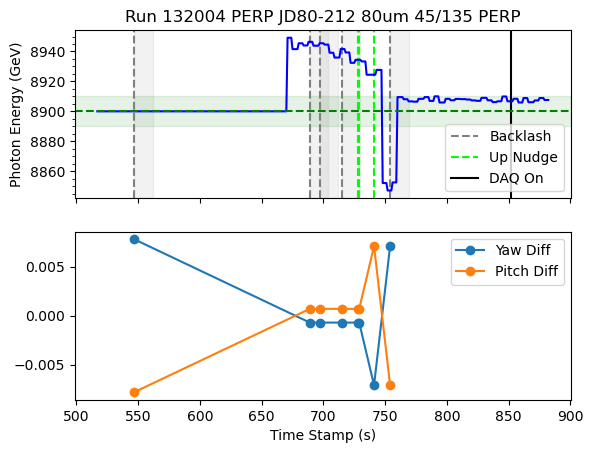

plotting for run  132006
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    125
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

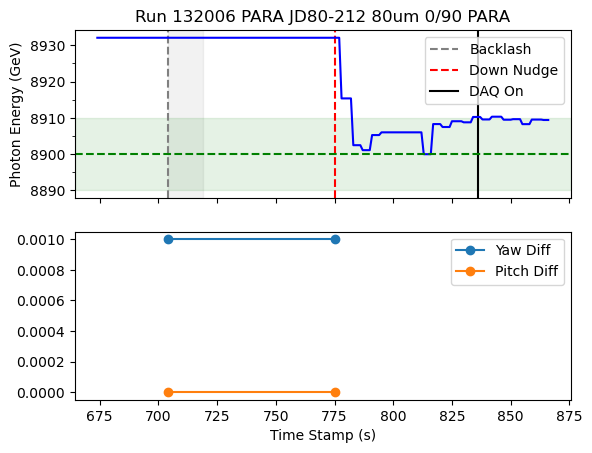

plotting for run  132009
Full nudge sequence is  0    uudddddddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[12] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
RADIATOR:NAME
JD80-212 80um 0/90 deg    353
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

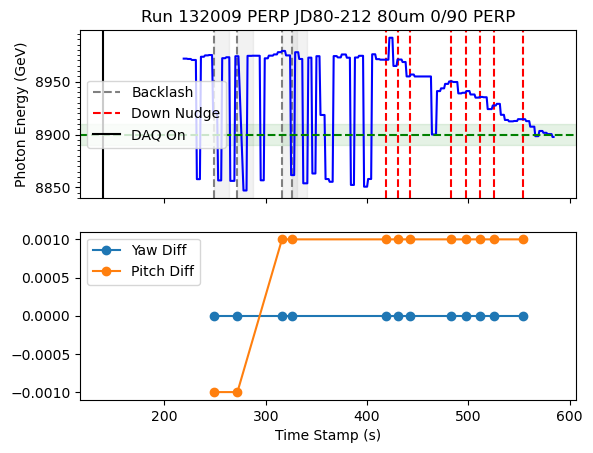

plotting for run  132010
Full nudge sequence is  0    udddddddduuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[13] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
RADIATOR:NAME
JD80-212 80um 0/90 deg    1095
Undefined                   12
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

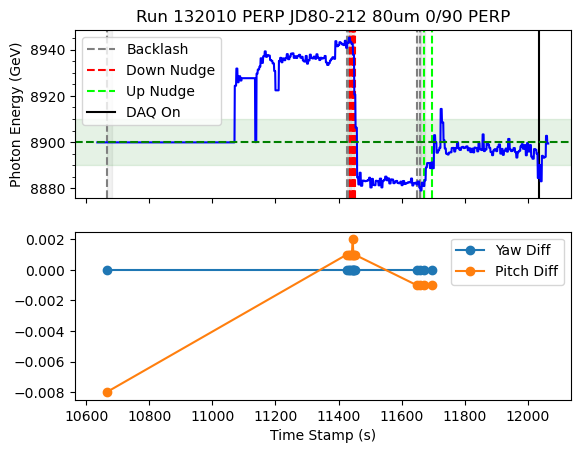

plotting for run  132017
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    142
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

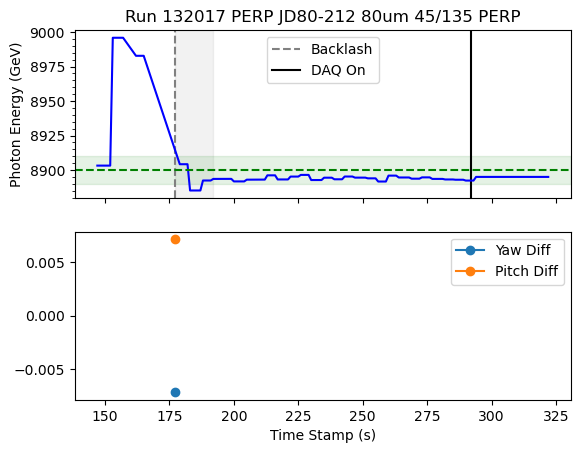

plotting for run  132021
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    215
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

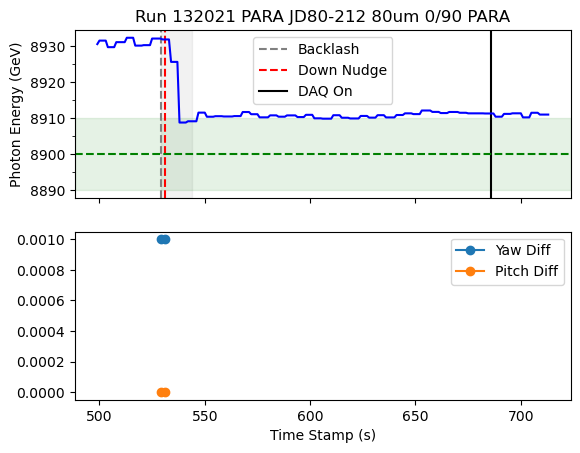

plotting for run  132024
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    226
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

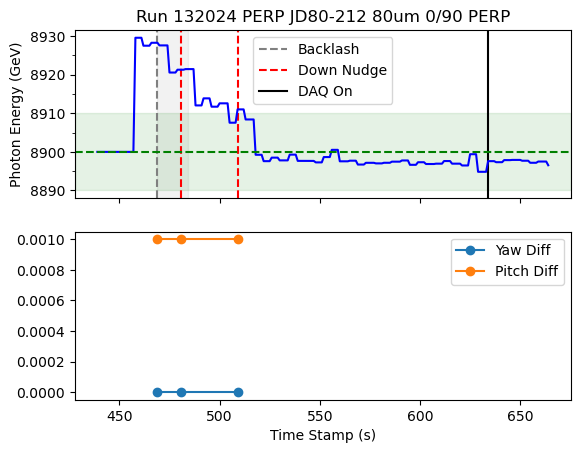

plotting for run  132033
Full nudge sequence is  0    duuuuuuuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[11] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
RADIATOR:NAME
JD80-212 80um 45/135 deg    575
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

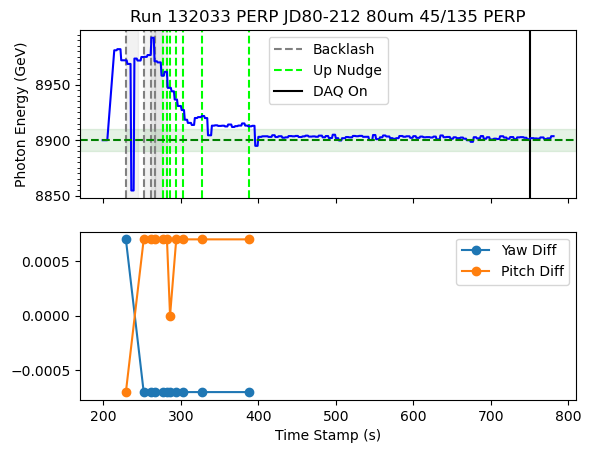

plotting for run  132039
Full nudge sequence is  0    uuuuuuuuuuuuuuuduuuuuuuuuuuuuuuuuuuuuudududdddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
Name: NudgeSequenceReduced_Correct, dtype: object
[47] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
seq val is  30
seq val is  31
seq val is  32
seq val is  33
seq val is  34
seq val is  35
seq val is  36
seq val is  37
seq val is  38
seq val is  39
seq val is  40
seq val is  4

<Figure size 640x480 with 0 Axes>

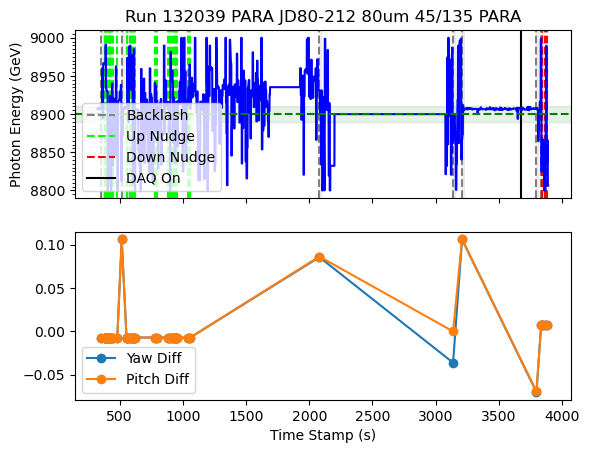

plotting for run  132040
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 132040
plotting for run  132058
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 132058
plotting for run  132061
Full nudge sequence is  0    duuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges th

<Figure size 640x480 with 0 Axes>

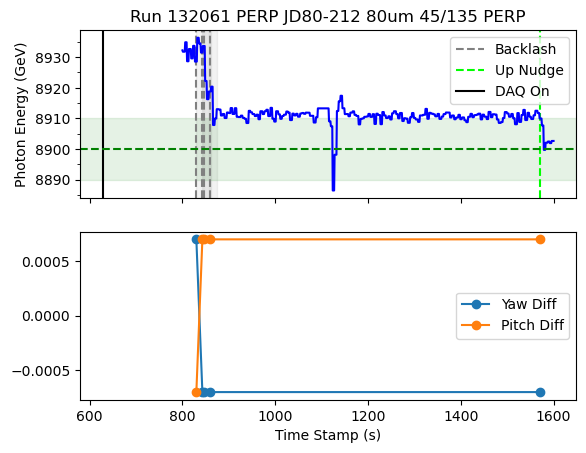

plotting for run  132065
Full nudge sequence is  Series([], Name: NudgeSequence, dtype: object)
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[0] nudges this run
ERROR: First nudge df is empty, skipping Run 132065
plotting for run  132071
Full nudge sequence is  0    uuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uu
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 45/135 deg    121
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

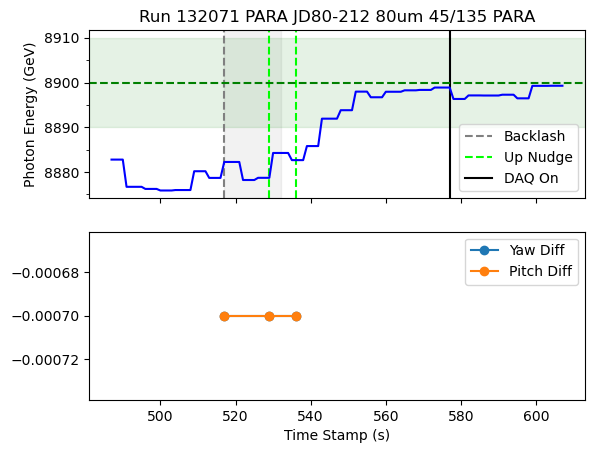

plotting for run  132088
Full nudge sequence is  0    duuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...
Name: NudgeSequenceReduced_Correct, dtype: object
[474] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
seq val is  7
seq val is  8
seq val is  9
seq val is  10
seq val is  11
seq val is  12
seq val is  13
seq val is  14
seq val is  15
seq val is  16
seq val is  17
seq val is  18
seq val is  19
seq val is  20
seq val is  21
seq val is  22
seq val is  23
seq val is  24
seq val is  25
seq val is  26
seq val is  27
seq val is  28
seq val is  29
seq val is  30
seq val is  31
seq val is  32
seq val is  33
seq val is  34
seq val is  35
seq val is  36
seq val is  37
seq val is  38
seq 

<Figure size 640x480 with 0 Axes>

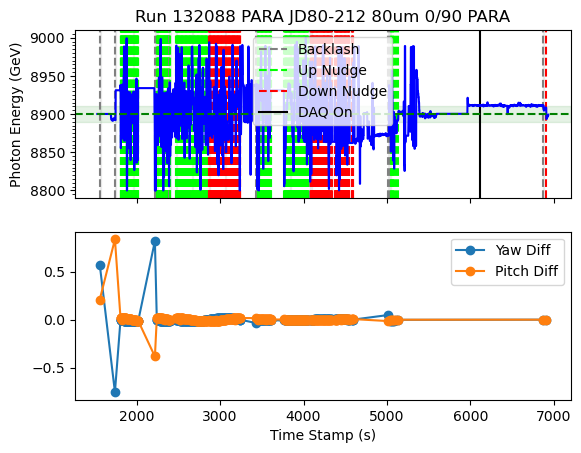

plotting for run  132093
Full nudge sequence is  0    dudd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 0/90 deg    137
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

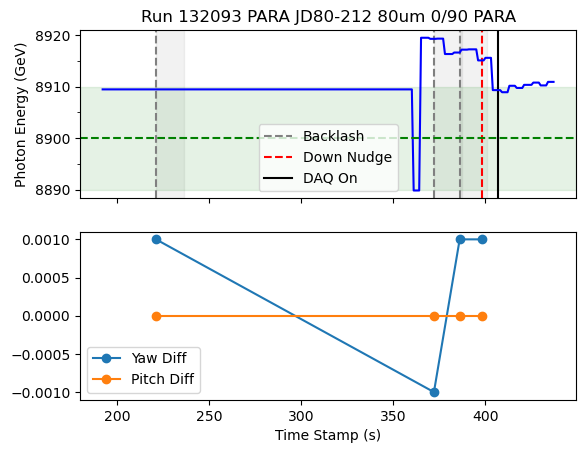

plotting for run  132095
Full nudge sequence is  0    ddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dddd
Name: NudgeSequenceReduced_Correct, dtype: object
[5] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
RADIATOR:NAME
JD80-212 80um 0/90 deg    211
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

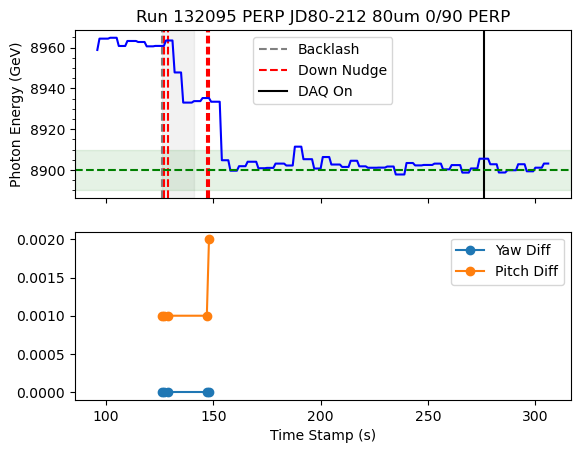

plotting for run  132100
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    107
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

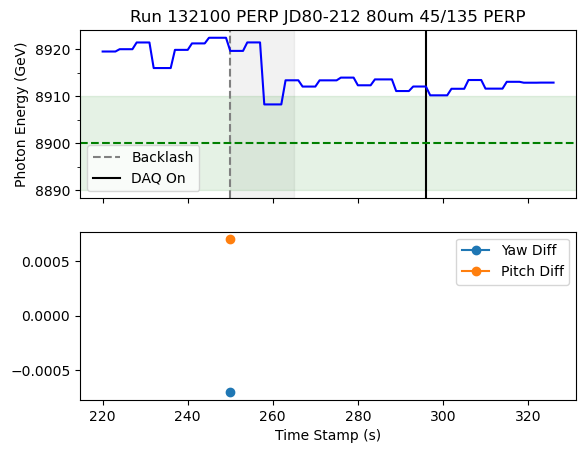

plotting for run  132104
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    79
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

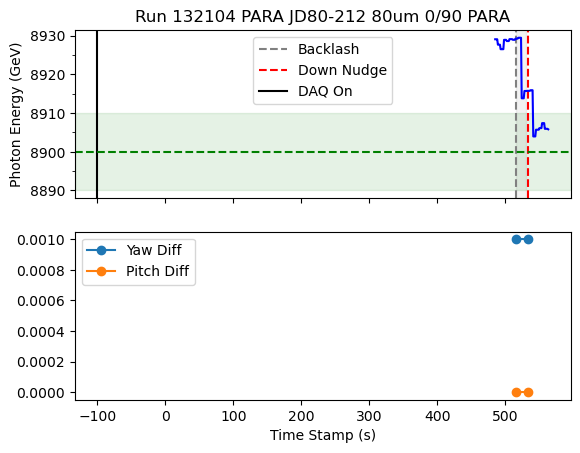

plotting for run  132108
Full nudge sequence is  0    dddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD80-212 80um 0/90 deg    513
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

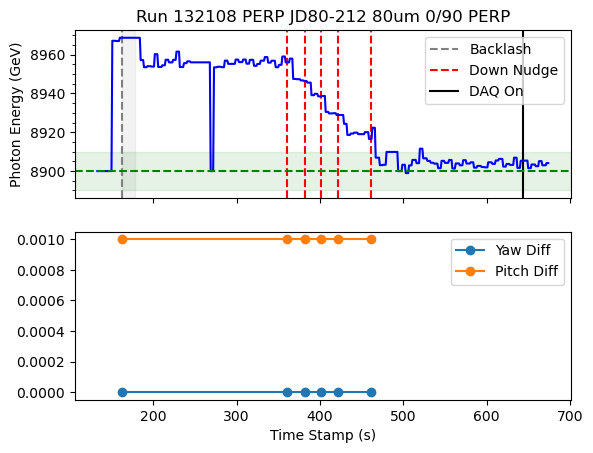

plotting for run  132110
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    54
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

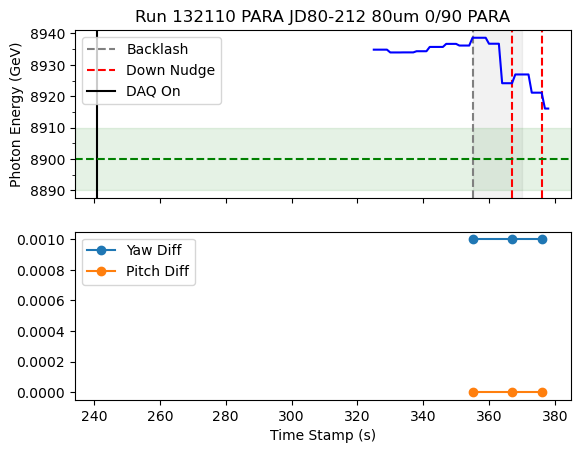

plotting for run  132111
Full nudge sequence is  0    du
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  Series([], Name: NudgeSequenceReduced_Naive, dtype: object)
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    155
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

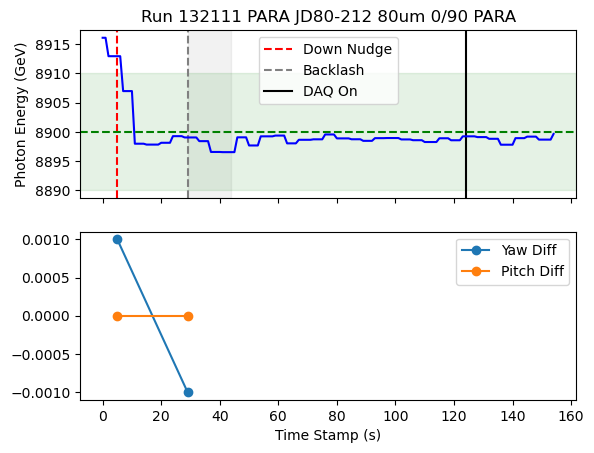

plotting for run  132113
Full nudge sequence is  0    uddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[4] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
RADIATOR:NAME
JD80-212 80um 45/135 deg    327
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

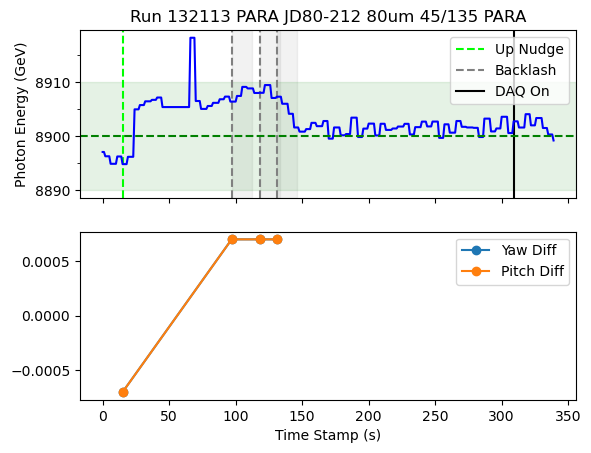

plotting for run  132126
Full nudge sequence is  0    duu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    u
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    464
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

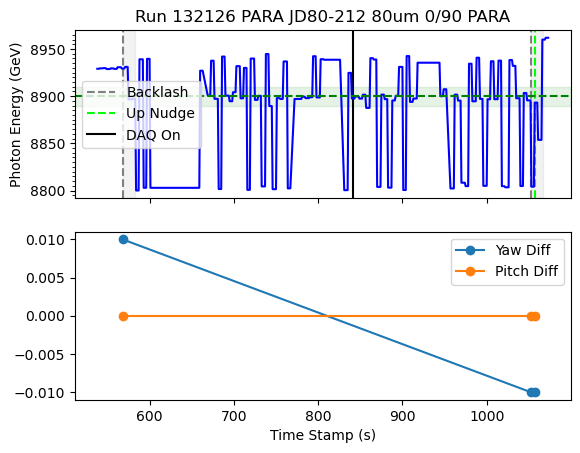

plotting for run  132127
Full nudge sequence is  0    ddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    ddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    dd
Name: NudgeSequenceReduced_Correct, dtype: object
[3] nudges this run
seq val is  1
seq val is  2
seq val is  3
RADIATOR:NAME
JD80-212 80um 0/90 deg    211
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

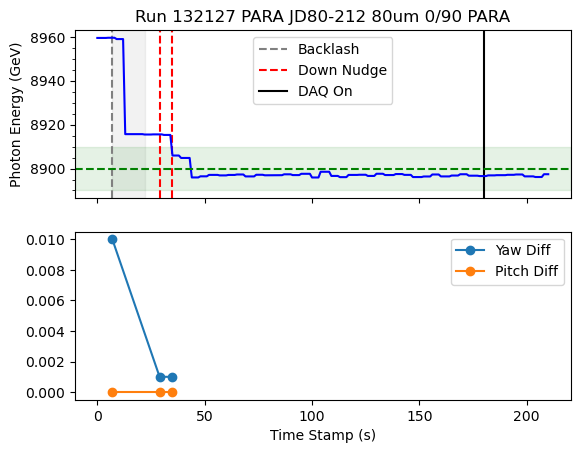

plotting for run  132137
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    102
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

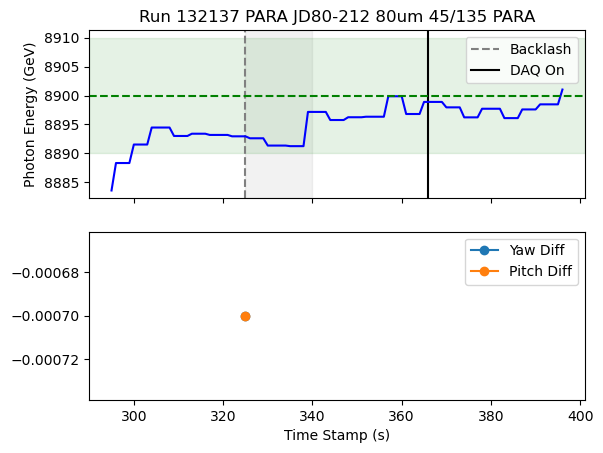

plotting for run  132139
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    369
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

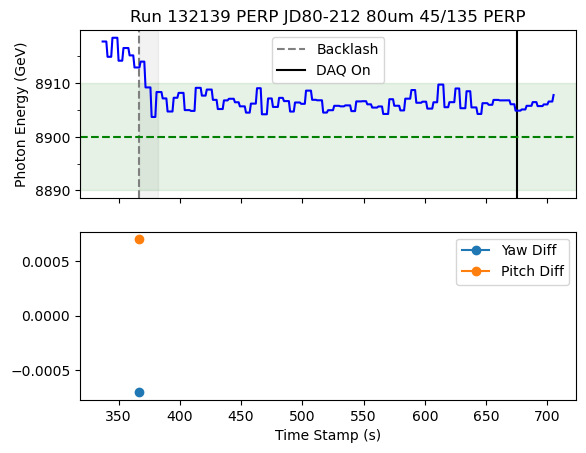

plotting for run  132142
Full nudge sequence is  0    dd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    d
Name: NudgeSequenceReduced_Correct, dtype: object
[2] nudges this run
seq val is  1
seq val is  2
RADIATOR:NAME
JD80-212 80um 0/90 deg    148
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

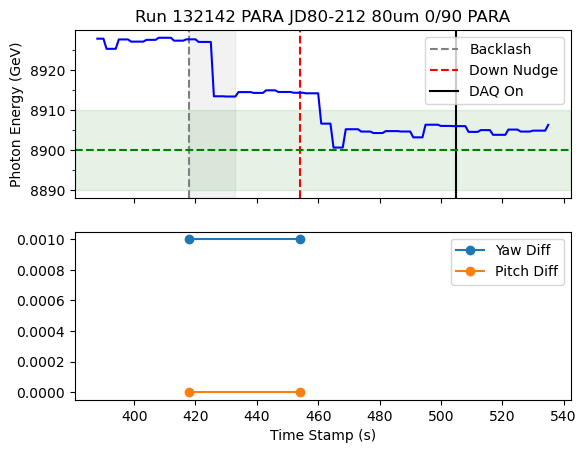

plotting for run  132145
Full nudge sequence is  0    dddddd
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    dddddd
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    ddddd
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD80-212 80um 0/90 deg    147
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

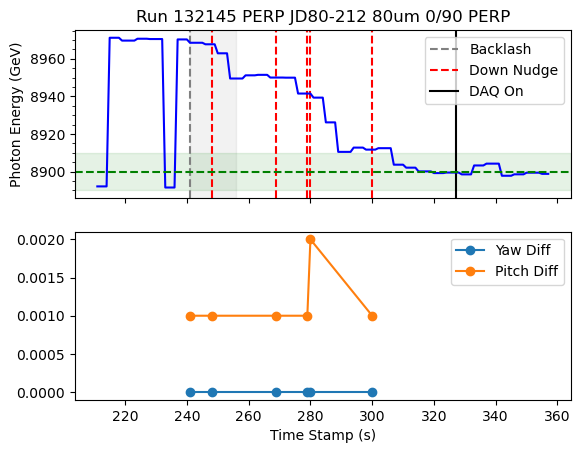

plotting for run  132152
Full nudge sequence is  0    u
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    u
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  Series([], Name: NudgeSequenceReduced_Correct, dtype: object)
[1] nudges this run
seq val is  1
RADIATOR:NAME
JD80-212 80um 45/135 deg    196
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

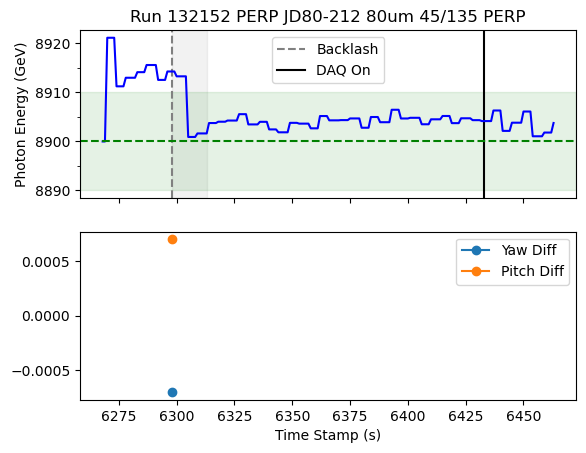

plotting for run  132158
Full nudge sequence is  0    duuuuu
Name: NudgeSequence, dtype: object
Reduced nudge sequence is  0    uuuu
Name: NudgeSequenceReduced_Naive, dtype: object
Reduced nudge sequence w/ backlash is  0    uuu
Name: NudgeSequenceReduced_Correct, dtype: object
[6] nudges this run
seq val is  1
seq val is  2
seq val is  3
seq val is  4
seq val is  5
seq val is  6
RADIATOR:NAME
JD80-212 80um 0/90 deg    286
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

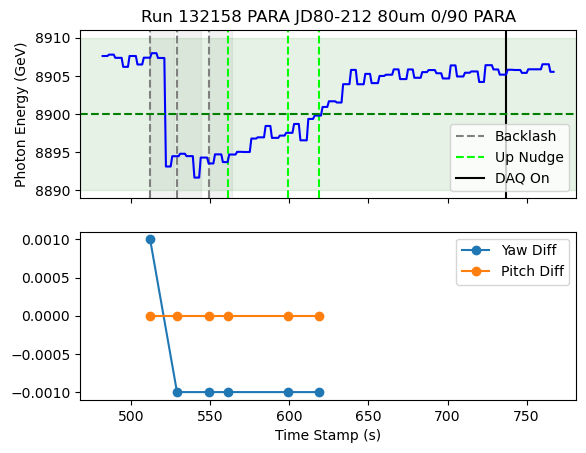

<Figure size 640x480 with 0 Axes>

In [10]:
for runNum in backlash_runs_2025:
    plot_run(df_2025_good,runNum)